## 1. Read the data

In [4]:
# Read the data 
import pandas as pd
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data cleaning

In [5]:
# Check for missing values
data_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily we have no missing data, proceeding to look at distribution of numerical and categorical features

In [6]:
# check for distribution of numerical features
data_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# get summary of categorical features
data_df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


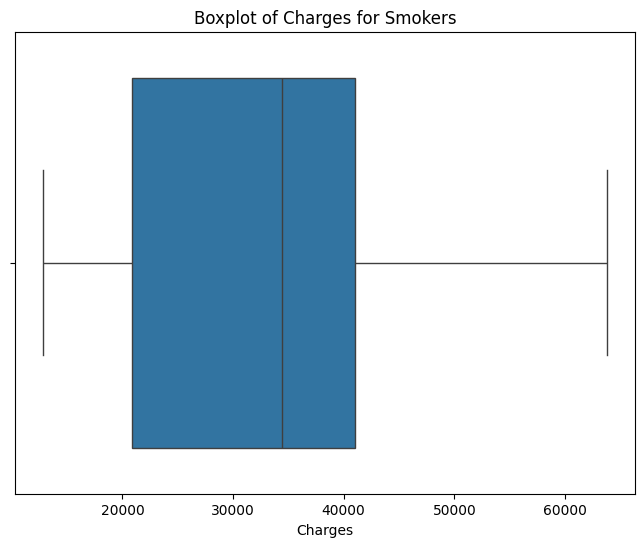

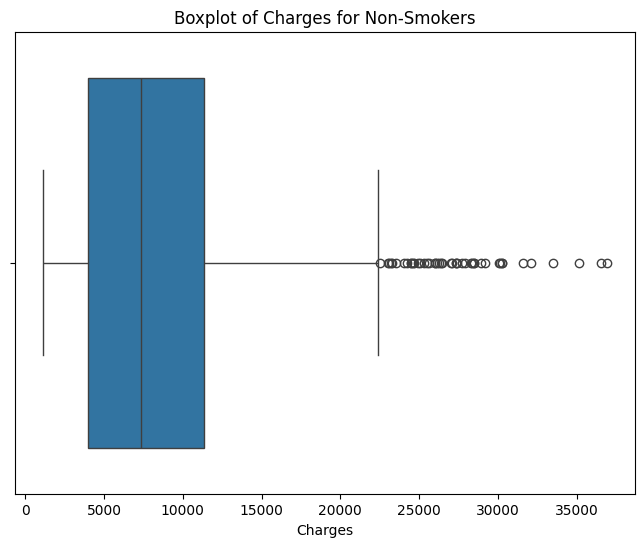

In [8]:
# Identify outliers in charges for smokers and non-smokers separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x=smoker_df['charges'])
plt.title('Boxplot of Charges for Smokers')
plt.xlabel('Charges')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=non_smoker_df['charges'])
plt.title('Boxplot of Charges for Non-Smokers')
plt.xlabel('Charges')
plt.show()

The data looks skewed towards non-smokers over smokers.  Proceeding to look at the correlation matrix.

Number of outliers in charges for non-smoker group: 46


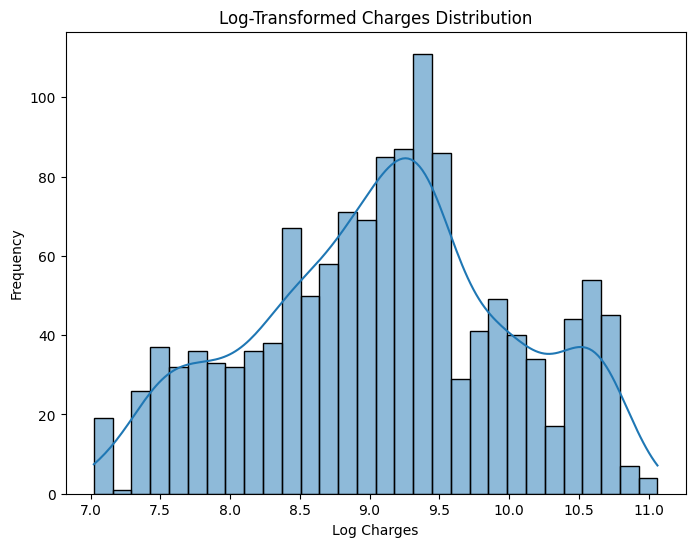

(1292, 8)

In [9]:
# count the number of outliers in charges for non-smoker group
Q1 = non_smoker_df['charges'].quantile(0.25)
Q3 = non_smoker_df['charges'].quantile(0.75)
IQR = Q3 - Q1
outliers = non_smoker_df[(non_smoker_df['charges'] < (Q1 - 1.5 * IQR)) | (non_smoker_df['charges'] > (Q3 + 1.5 * IQR))]
print(f'Number of outliers in charges for non-smoker group: {outliers.shape[0]}')
# Log transform the charges to reduce skewness
import numpy as np
data_df['log_charges'] = np.log1p(data_df['charges'])
plt.figure(figsize=(8, 6))
sns.histplot(data_df['log_charges'], bins=30, kde=True)
plt.title('Log-Transformed Charges Distribution')
plt.xlabel('Log Charges')
plt.ylabel('Frequency')
plt.show()
# Drop the outliers from non-smoker group
data_df = data_df[~data_df.index.isin(outliers.index)]
data_df.reset_index(drop=True, inplace=True)
data_df.shape

## 3. Plotting, scaling, normalizing

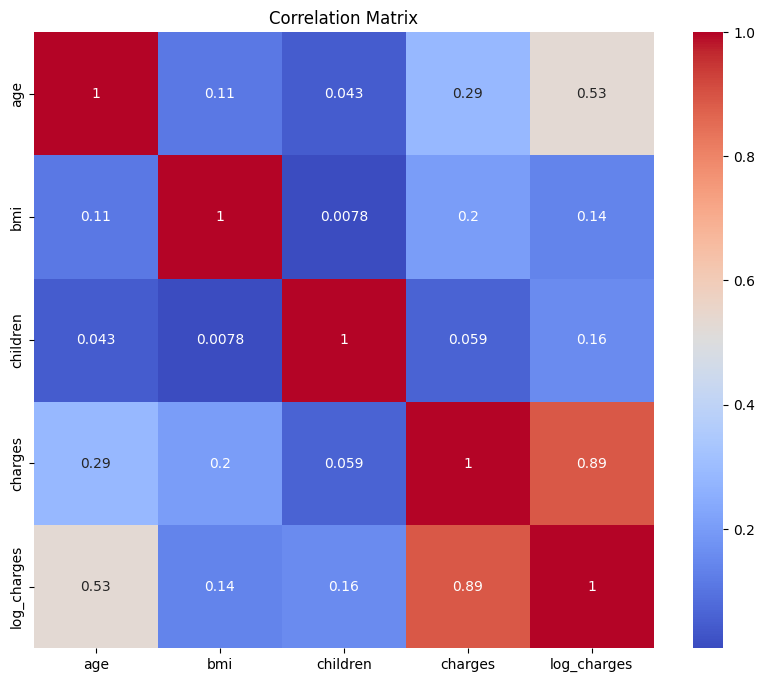

In [10]:
# plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# only numerical features are considered for correlation
numerical_features = data_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

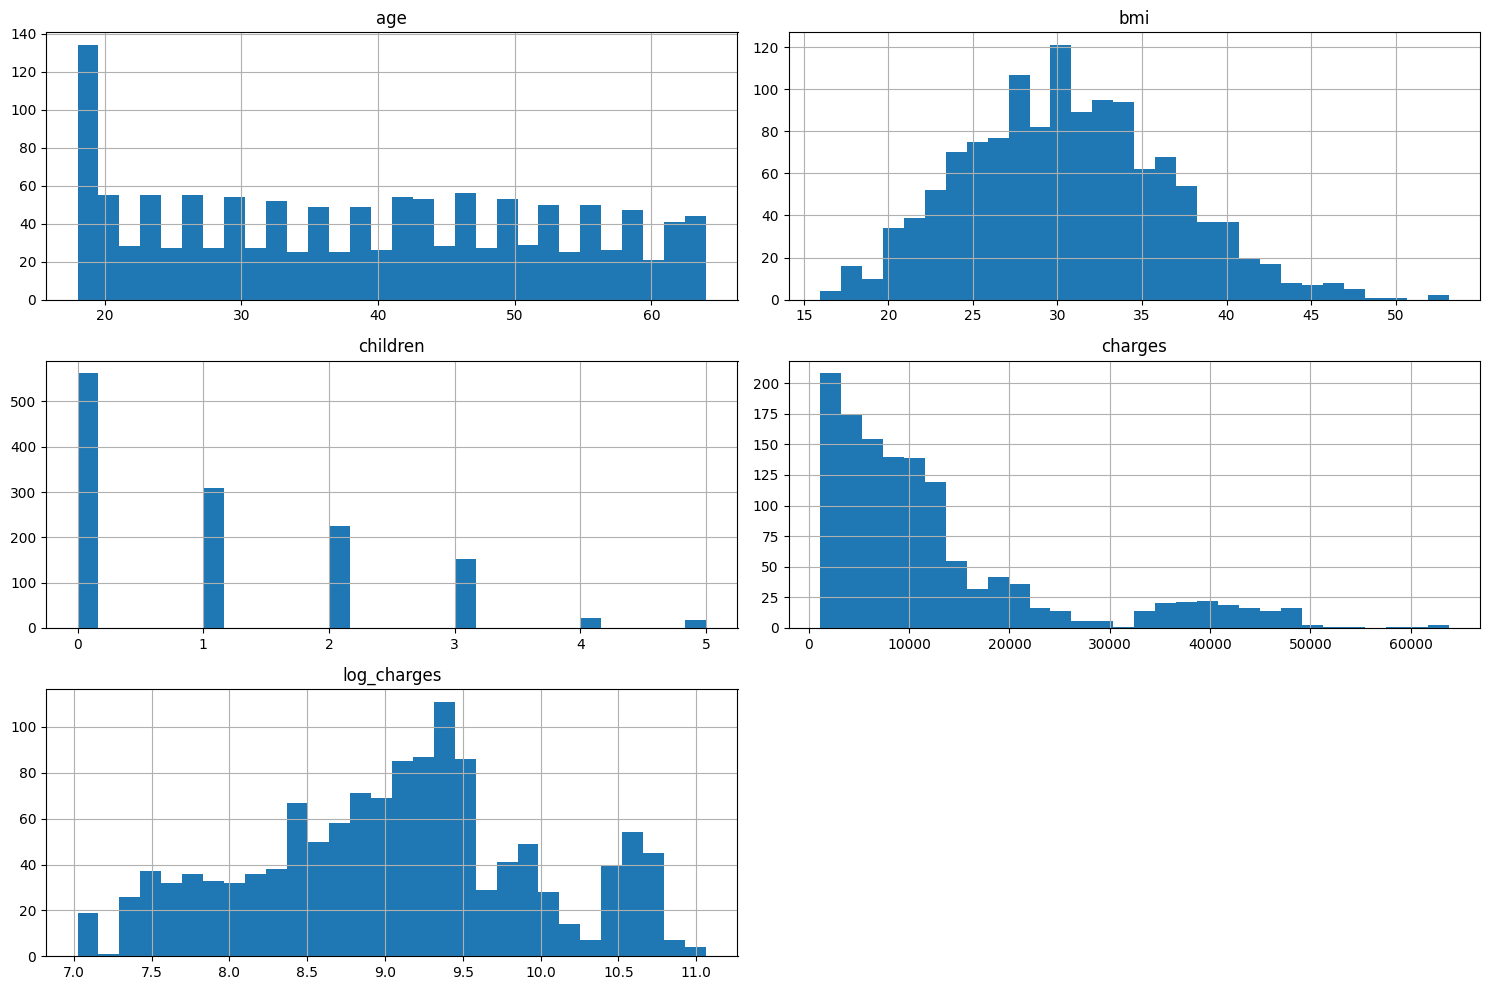

In [11]:
# plot a grid of histograms of charges and the other features to see their distributions
data_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

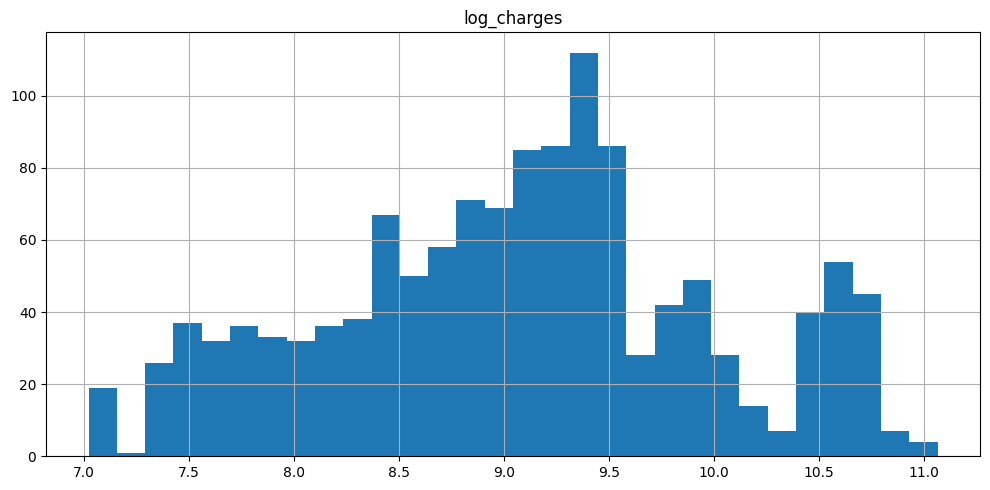

In [12]:
# Since age and charges are right skewed, we can apply log transformation to them
import numpy as np
data_df['log_charges'] = np.log(data_df['charges'])
data_df[['log_charges']].hist(bins=30, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [13]:
# Drop the original charges column
data_df = data_df.drop(columns=['charges'])

In [14]:
# normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['age', 'bmi']
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])
data_df.head()

,age,sex,bmi,children,smoker,region,log_charges
0,-1.426073,female,-0.449927,0,yes,southwest,9.734176
1,-1.497543,male,0.507786,1,no,southeast,7.453302
2,-0.782847,male,0.382157,3,no,southeast,8.400538
3,-0.425499,male,-1.297510,0,no,northwest,9.998092
4,-0.496968,male,-0.290036,0,no,northwest,8.260197


## 4. Baseline model - Simple linear regression

In [15]:
# model the relationship between charges (y) and the other features (X) using simple linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 10 fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV: {r2_scores.mean()}')
# Fit the model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Average MSE from 10-fold CV: 0.15534187482359765
Average R2 from 10-fold CV: 0.8021928949660054
Test MSE: 0.13235118438134155
Test R2: 0.8459414504333728


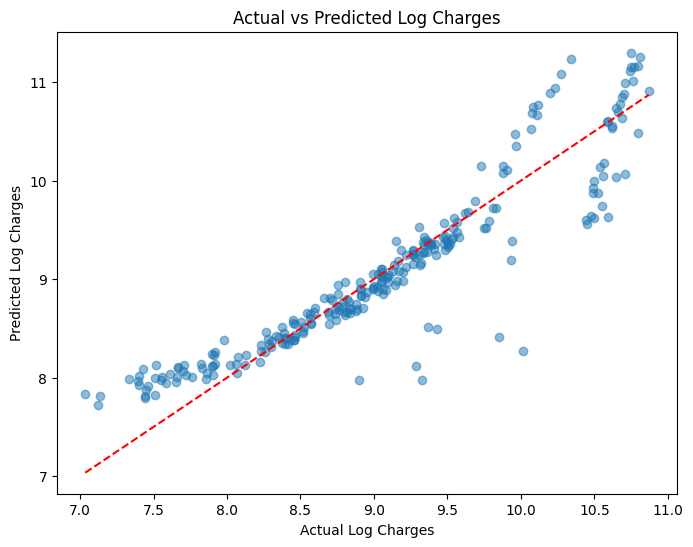

In [16]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

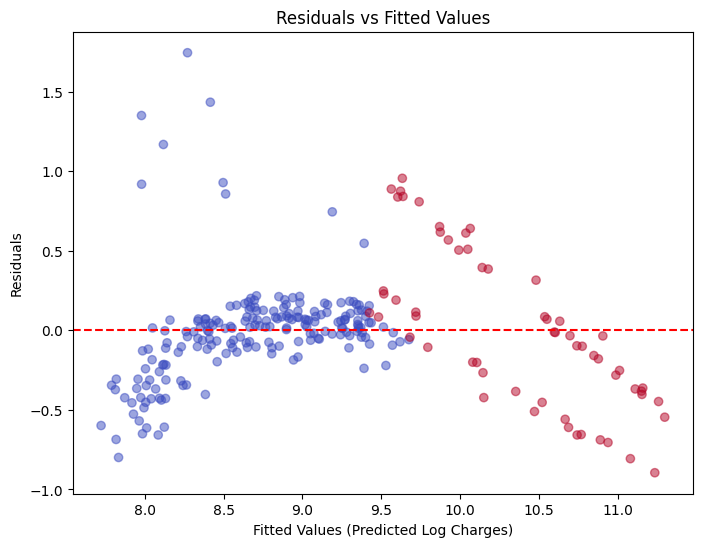

In [17]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Now that we have a baseline, we can explore more complex models and feature engineering techniques to improve performance.

## 5. Feature engineering and other approaches

###  5.1 Adding interaction terms and running Linear Regression again

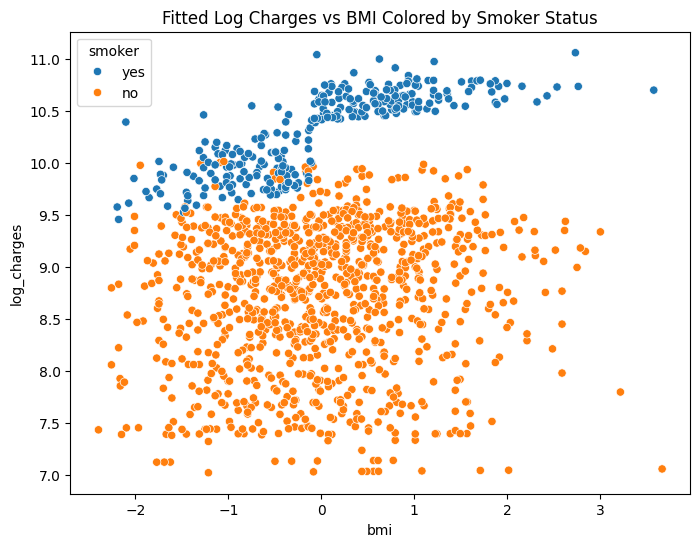

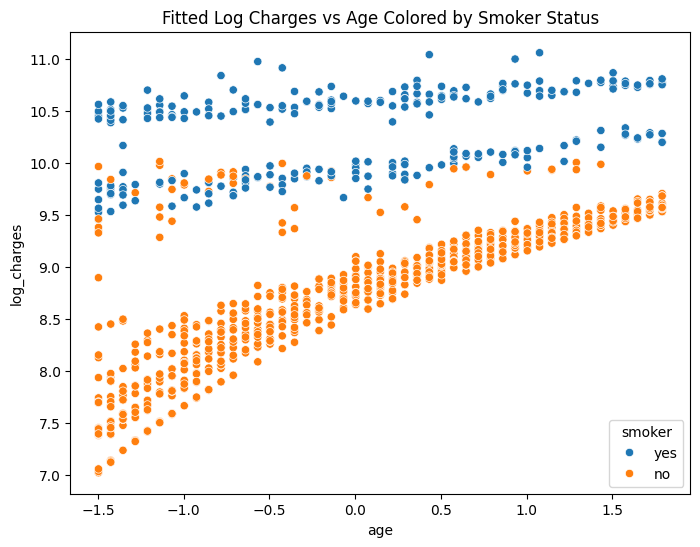

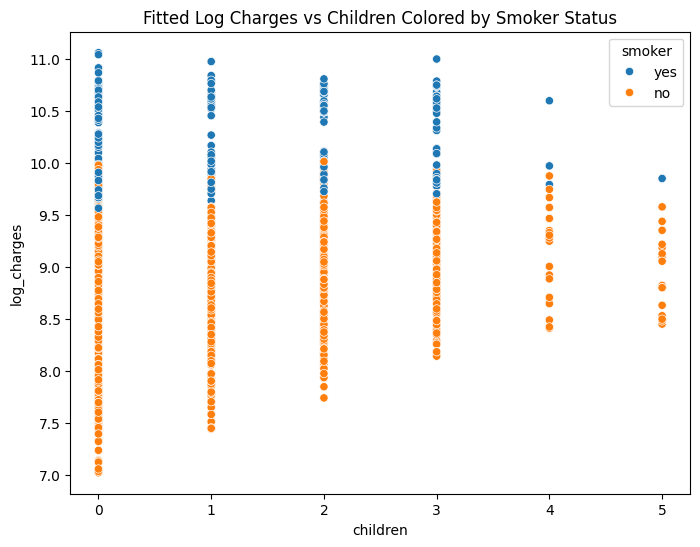

In [18]:
# Since smoker is the most important feature, plot a scatter plot of fitted charges vs each numerical feature colored by smoker status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs BMI Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Age Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='children', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Children Colored by Smoker Status')
plt.show()

From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, so considering a split in this group as a new feature and adding an interaction term between the new feature and smoker in the new model

In [19]:
# From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, 
# so considering a split in this group as a new feature and 
# adding an interaction term between the new feature and smoker in the new model   
data_df['high_bmi'] = (data_df['bmi'] > 30).astype(int)
data_df['high_bmi_smoker_interaction'] = data_df['high_bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df['high_bmi_bmi_interaction'] = data_df['high_bmi'] * data_df['bmi']
data_df['bmi_smoker_interaction'] = data_df['bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df.drop(['high_bmi'], axis=1, inplace=True)
# Re-define features and target variable with the new feature
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use 10 fold cross-validation to evaluate the new model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV after adding high_bmi_smoker feature: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV after adding high_bmi_smoker feature: {r2_scores.mean()}')
# Fit the new model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the new model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE after adding high_bmi_smoker feature: {mse}')
print(f'Test R2 after adding high_bmi_smoker feature: {r2}')

Average MSE from 10-fold CV after adding high_bmi_smoker feature: 0.14305500167998197
Average R2 from 10-fold CV after adding high_bmi_smoker feature: 0.8184074671078381
Test MSE after adding high_bmi_smoker feature: 0.11578235653866906
Test R2 after adding high_bmi_smoker feature: 0.865227787744164


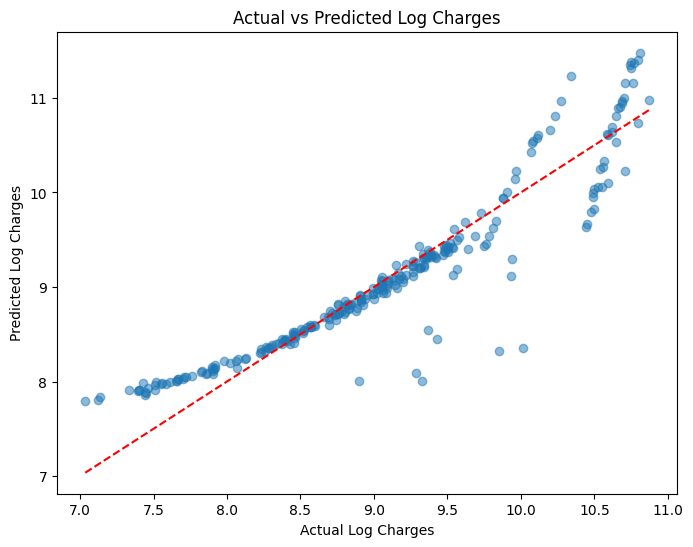

In [20]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

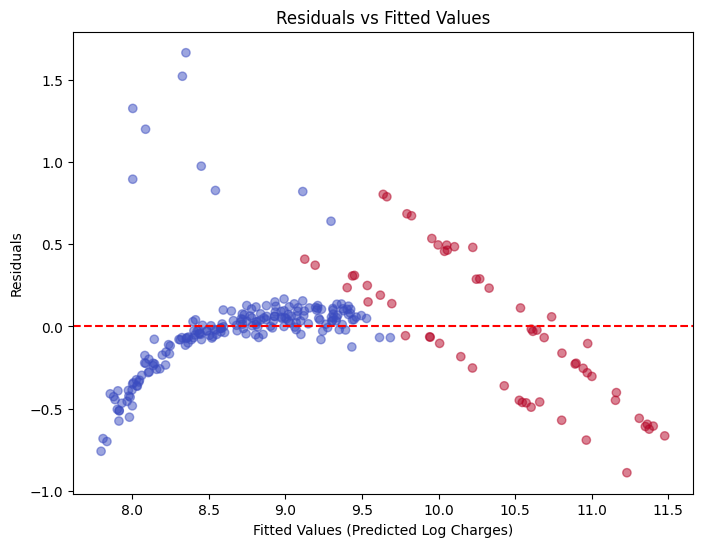

In [21]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We have a better fit now with the inclusion of the new feature, our test R2 has gone up from 0.8047311493462986 to 0.8169560889305182

### 5.2 Random Forest with hyperparameter tuning

In [22]:
# Try using a Random Forest with hyperparameter tuning to see if we can improve the model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 11, 1),
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
# Predict on the test data using the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Test MSE: {mse_rf}')
print(f'Random Forest Test R2: {r2_rf}')

Random Forest Test MSE: 0.06760374428447521
Random Forest Test R2: 0.9213083370698746


### 5.3 LightGBM with hyperparameter tuning

In [23]:
# use LightGBM to see if we can improve the model performance further
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# specify your configurations as a dict
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval)
# predict
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# evaluate
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM Test MSE: {mse_lgb}')
print(f'LightGBM Test R2: {r2_lgb}')

LightGBM Test MSE: 0.06389423514168062
LightGBM Test R2: 0.9256262553477834


### 5.4 XGBoost with hyperparameter tuning

In [24]:
# Run XGBoost to see if we can improve the model performance further using GridSearchCV for hyperparameter tuning
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 11, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
# Predict on the test data using the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Test MSE: {mse_xgb}')
print(f'XGBoost Test R2: {r2_xgb}')

XGBoost Test MSE: 0.05824654594939071
XGBoost Test R2: 0.932200241137441


The XGBoost algorithm has the best R2 of all algorithms so far, looking for opportunities to improve the model further.

### 5.5 Revisiting scatter plots

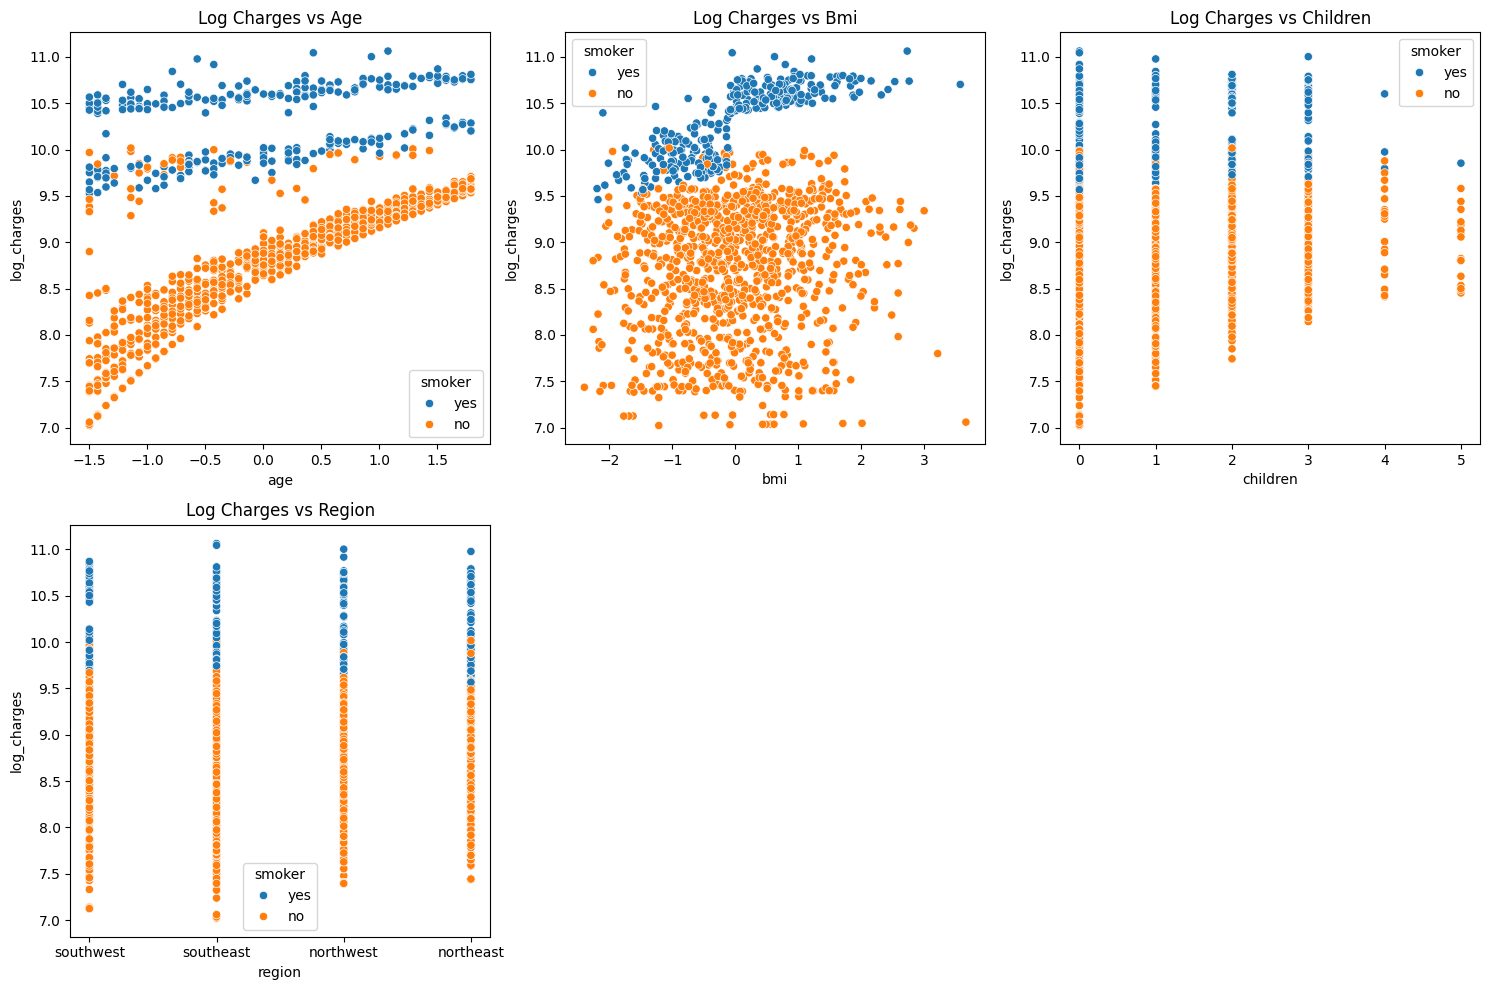

In [25]:
# create a grid of scatter plots of charges vs each of the input features to explore higher order interactions
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 10))

# Create a grid of scatter plots
features = ['age', 'bmi', 'children', 'region']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='log_charges', data=data_df, hue='smoker')
    plt.title(f'Log Charges vs {feature.capitalize()}')

plt.tight_layout()
plt.show()

### 5.6 Splitting data as smoker and non-smoker, fitting separate models

In [26]:
# Split the data into smoker and non-smoker groups and analyze the model performance separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']
# Define features and target variable for smoker group
X_smoker = smoker_df.drop('log_charges', axis=1)
y_smoker = smoker_df['log_charges']
# One-hot encode categorical variables
X_smoker = pd.get_dummies(X_smoker, drop_first=True)
# Use train-test split
X_train_smoker, X_test_smoker, y_train_smoker, y_test_smoker = train_test_split(X_smoker, y_smoker, test_size=0.2, random_state=42)


# Use hyperparameter tuning to find the best XGBoost model for smoker group
xgb_model_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_smoker = {
    'n_estimators': [20,50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_search_xgb_smoker = GridSearchCV(estimator=xgb_model_smoker, param_grid=param_grid_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_smoker.fit(X_train_smoker, y_train_smoker)
best_xgb_smoker = grid_search_xgb_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for smoker group
y_pred_xgb_smoker = best_xgb_smoker.predict(X_test_smoker)
# Evaluate the XGBoost model for smoker group
mse_xgb_smoker = mean_squared_error(y_test_smoker, y_pred_xgb_smoker)
r2_xgb_smoker = r2_score(y_test_smoker, y_pred_xgb_smoker)
print(f'XGBoost Test MSE for Smoker Group: {mse_xgb_smoker}')
print(f'XGBoost Test R2 for Smoker Group: {r2_xgb_smoker}') 

XGBoost Test MSE for Smoker Group: 0.013630194037895069
XGBoost Test R2 for Smoker Group: 0.9146997559751213


In [27]:
# do the same for non-smoker group
# Define features and target variable for non-smoker group
X_non_smoker = non_smoker_df.drop('log_charges', axis=1)
y_non_smoker = non_smoker_df['log_charges']
# One-hot encode categorical variables
X_non_smoker = pd.get_dummies(X_non_smoker, drop_first=True)
# Use train-test split
X_train_non_smoker, X_test_non_smoker, y_train_non_smoker, y_test_non_smoker = train_test_split(X_non_smoker, y_non_smoker, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for non-smoker group
xgb_model_non_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker = GridSearchCV(estimator=xgb_model_non_smoker, param_grid=param_grid_non_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker.fit(X_train_non_smoker, y_train_non_smoker)
best_xgb_non_smoker = grid_search_xgb_non_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group
y_pred_xgb_non_smoker = best_xgb_non_smoker.predict(X_test_non_smoker)
# Evaluate the XGBoost model for non-smoker group
mse_xgb_non_smoker = mean_squared_error(y_test_non_smoker, y_pred_xgb_non_smoker)
r2_xgb_non_smoker = r2_score(y_test_non_smoker, y_pred_xgb_non_smoker)
print(f'XGBoost Test MSE for Non-Smoker Group: {mse_xgb_non_smoker}')
print(f'XGBoost Test R2 for Non-Smoker Group: {r2_xgb_non_smoker}')

XGBoost Test MSE for Non-Smoker Group: 0.07582782144213594
XGBoost Test R2 for Non-Smoker Group: 0.8315492897884069


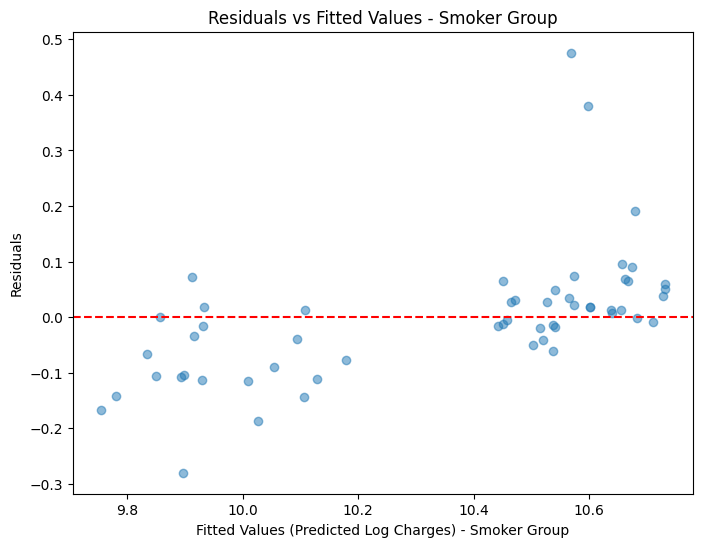

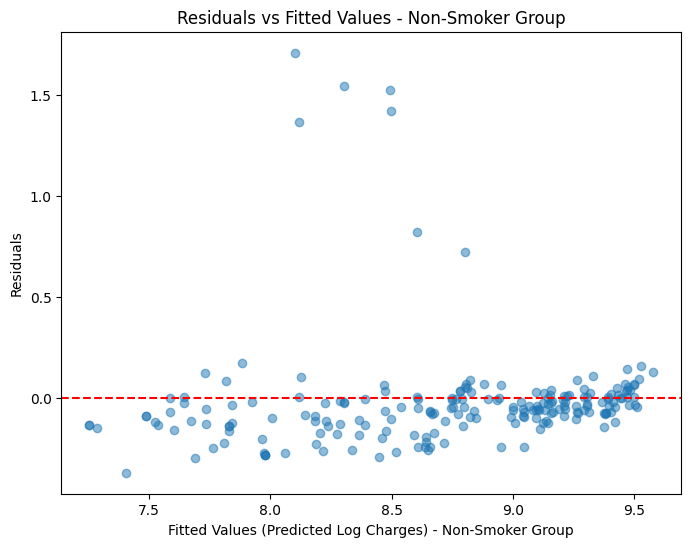

In [28]:
# plot the residuals vs fitted values for smoker and non-smoker groups separately
# smoker group
residuals_smoker = y_test_smoker - y_pred_xgb_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_smoker, residuals_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Smoker Group')
plt.show()
# non-smoker group
residuals_non_smoker = y_test_non_smoker - y_pred_xgb_non_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_non_smoker, residuals_non_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Non-Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Non-Smoker Group')
plt.show()

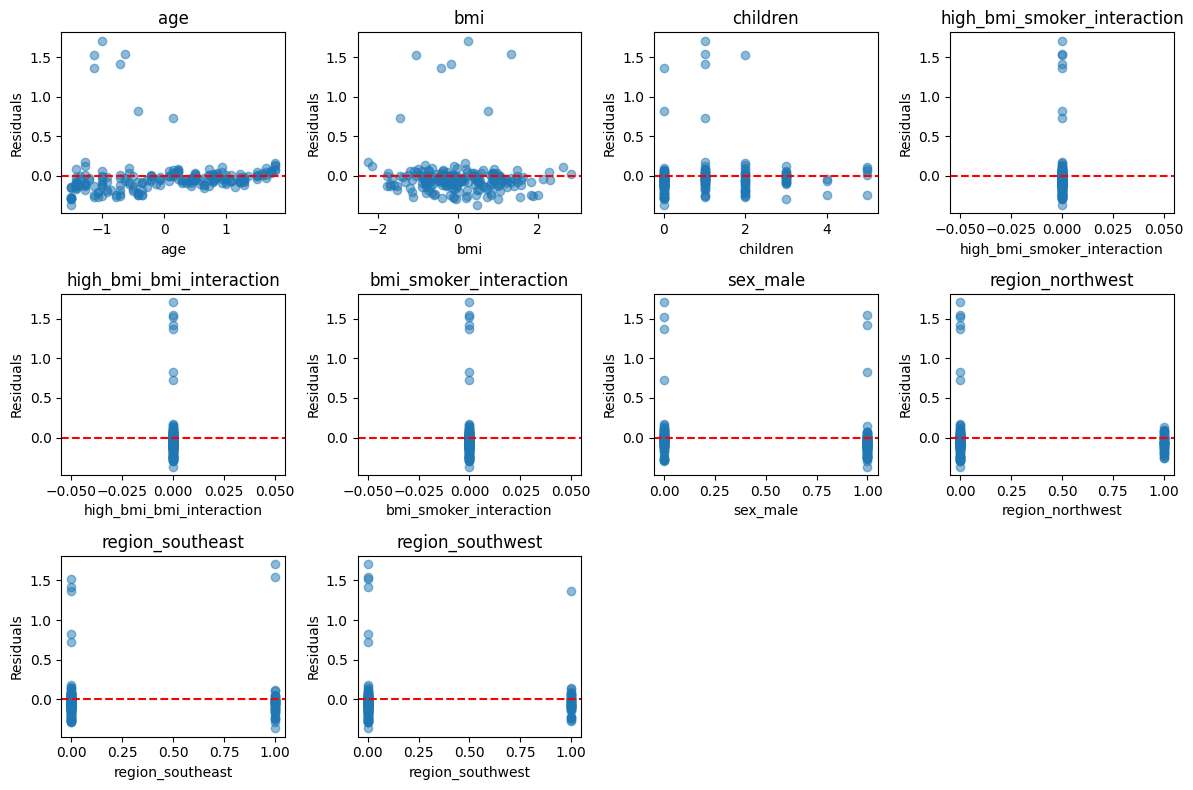

In [29]:
# Plot residuals vs each of the individual features
import matplotlib.pyplot as plt

# Get residuals
residuals = y_test_non_smoker - y_pred_xgb_non_smoker

# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test_non_smoker.columns):
    plt.subplot(3, 4, i + 1)
    plt.scatter(X_test_non_smoker[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [30]:
# Exploring higher order interactions (quadratic, cubic,...) for non-smoker group for age alone
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
# Create polynomial features for age up to degree 5
poly = PolynomialFeatures(degree=5, include_bias=False)
age_poly = poly.fit_transform(non_smoker_df[['age']])
age_poly_df = pd.DataFrame(age_poly, columns=[f'age_deg_{i}' for i in range(1, age_poly.shape[1] + 1)])
print(f'Age polynomial group shape: {age_poly_df.shape}')
# Add polynomial age features to non_smoker_df
non_smoker_df_poly = pd.concat([non_smoker_df.reset_index(drop=True), age_poly_df.reset_index(drop=True)], axis=1)
# Define features and target variable for non-smoker group with polynomial age features
X_non_smoker_poly = non_smoker_df_poly.drop(['age', 'age_deg_1','log_charges'], axis=1)
print(f'X_non_smoker_poly initial shape: {X_non_smoker_poly.shape}')
y_non_smoker_poly = non_smoker_df['log_charges']
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# One-hot encode categorical variables
X_non_smoker_poly = pd.get_dummies(X_non_smoker_poly, drop_first=True)
# print dimensions of X_non_smoker_poly and y_non_smoker_poly
print(f'Non-smoker group shape: {non_smoker_df.shape}')
print(f'X_non_smoker_poly shape: {X_non_smoker_poly.shape}')
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# Use train-test split
X_train_non_smoker_poly, X_test_non_smoker_poly, y_train_non_smoker_poly, y_test_non_smoker_poly = train_test_split(X_non_smoker_poly, y_non_smoker_poly, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for non-smoker group with polynomial age features
xgb_model_non_smoker_poly = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker_poly = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker_poly = GridSearchCV(estimator=xgb_model_non_smoker_poly, param_grid=param_grid_non_smoker_poly, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker_poly.fit(X_train_non_smoker_poly, y_train_non_smoker_poly)
best_xgb_non_smoker_poly = grid_search_xgb_non_smoker_poly.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group with polynomial age features
y_pred_xgb_non_smoker_poly = best_xgb_non_smoker_poly.predict(X_test_non_smoker_poly)
# Evaluate the XGBoost model for non-smoker group with polynomial age features
mse_xgb_non_smoker_poly = mean_squared_error(y_test_non_smoker_poly, y_pred_xgb_non_smoker_poly)
r2_xgb_non_smoker_poly = r2_score(y_test_non_smoker_poly, y_pred_xgb_non_smoker_poly)
print(f'XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features: {mse_xgb_non_smoker_poly}')
print(f'XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features: {r2_xgb_non_smoker_poly}')


Age polynomial group shape: (1018, 5)
X_non_smoker_poly initial shape: (1018, 12)
y_non_smoker_poly shape: (1018,)
Non-smoker group shape: (1018, 10)
X_non_smoker_poly shape: (1018, 13)
y_non_smoker_poly shape: (1018,)
XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features: 0.07354188768015528
XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features: 0.8366274676705994


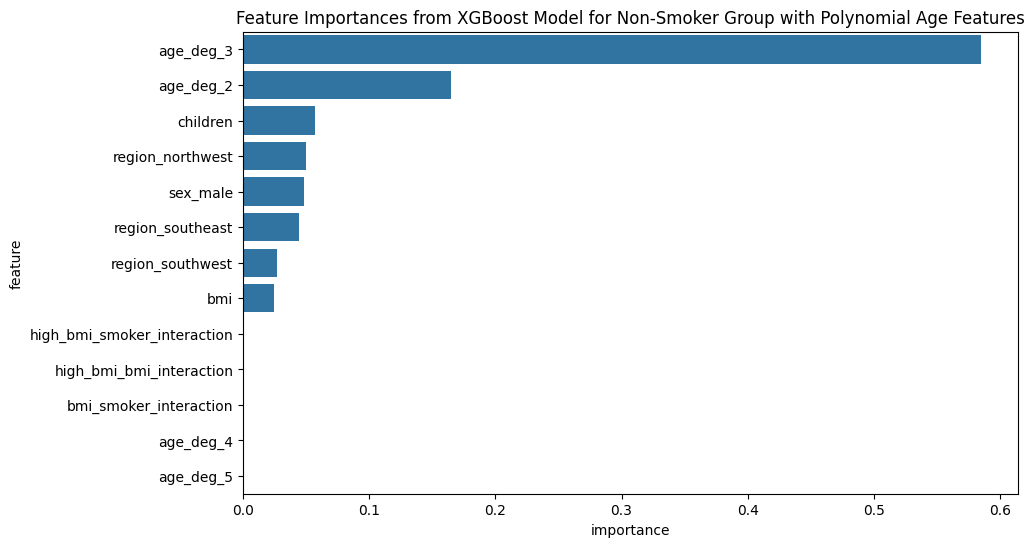

In [31]:
# get feature importances from the best_xgb_non_smoker_poly model
feature_importances = best_xgb_non_smoker_poly.feature_importances_
# create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': X_non_smoker_poly.columns, 'importance': feature_importances})
# sort the dataframe by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from XGBoost Model for Non-Smoker Group with Polynomial Age Features')
plt.show()

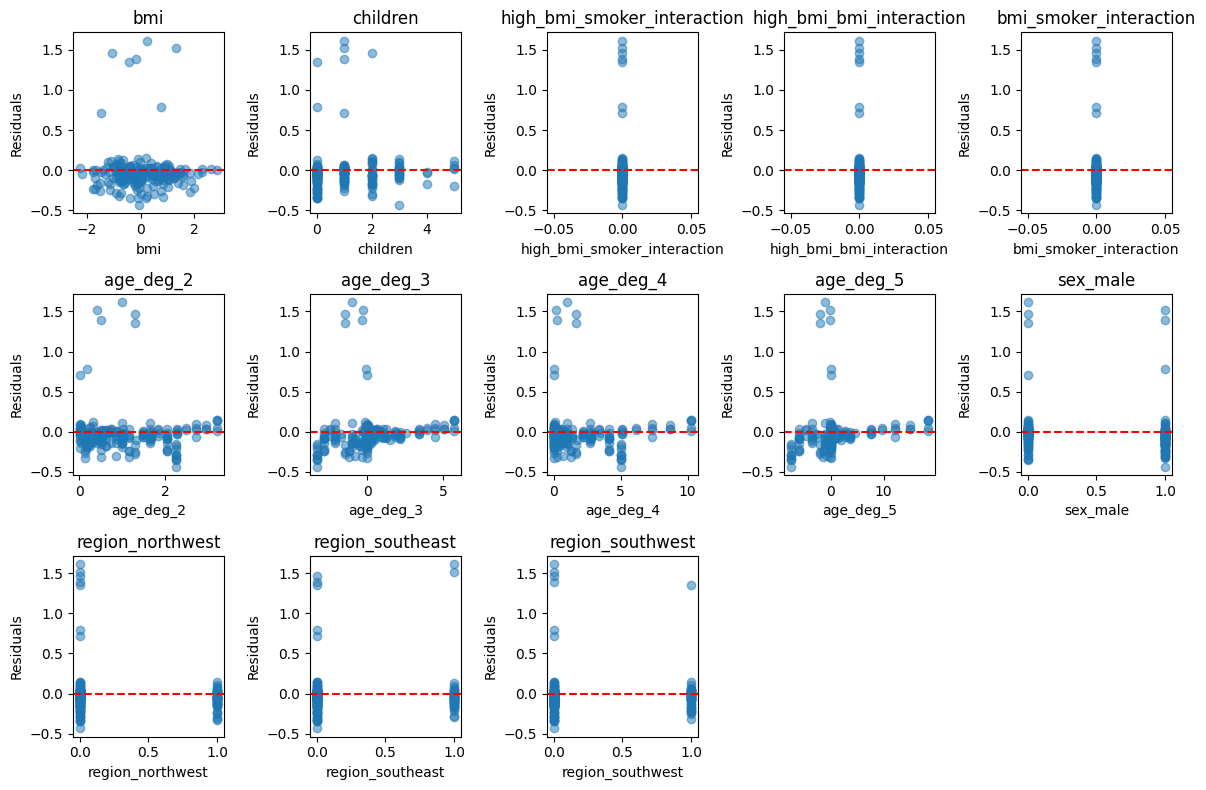

In [32]:
# Plot residuals vs each of the individual features
import matplotlib.pyplot as plt

# Get residuals
residuals = y_test_non_smoker_poly - y_pred_xgb_non_smoker_poly

# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test_non_smoker_poly.columns):
    plt.subplot(3, 5, i + 1)
    plt.scatter(X_test_non_smoker_poly[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [33]:
# Exploring higher order interactions (quadratic, cubic,...) for non-smoker group for bmi in addition to what was done for age
# Add a term for bmi>30 for overweight (adjusted for standardized bmi), add interaction terms between bmi and age polynomial features
# Create polynomial features for bmi up to degree 5
for i in range(1, 6):
    non_smoker_df_poly[f'bmi_deg_{i}'] = non_smoker_df_poly['bmi'] ** i
non_smoker_df_poly['high_bmi'] = (non_smoker_df_poly['bmi'] > (30 - data_df['bmi'].mean())/data_df['bmi'].std()).astype(int)
non_smoker_df_poly['high_bmi_bmi_interaction'] = non_smoker_df_poly['high_bmi'] * non_smoker_df_poly['bmi']
for i in range(1,6):
    non_smoker_df_poly[f'high_bmi_age_deg_{i}_interaction'] = non_smoker_df_poly['high_bmi'] * non_smoker_df_poly[f'age_deg_{i}']
# Define features and target variable for non-smoker group with polynomial age features and bmi interactions
X_non_smoker_poly = non_smoker_df_poly.drop(['age', 'age_deg_1','log_charges'], axis=1)
y_non_smoker_poly = non_smoker_df['log_charges']
# One-hot encode categorical variables
X_non_smoker_poly = pd.get_dummies(X_non_smoker_poly, drop_first=True)
# print dimensions of X_non_smoker_poly and y_non_smoker_poly
print(f'Non-smoker group shape: {non_smoker_df.shape}')
print(f'X_non_smoker_poly shape: {X_non_smoker_poly.shape}')
print(f'y_non_smoker_poly shape: {y_non_smoker_poly.shape}')
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X_non_smoker_poly, y_non_smoker_poly, test_size=0.2, random_state=42)

# Run XGBoost with hyperparameter tuning to find the best model for non-smoker group with polynomial age features and bmi interactions
xgb_model_non_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker = GridSearchCV(estimator=xgb_model_non_smoker, param_grid=param_grid_non_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker.fit(X_train, y_train)
best_xgb_non_smoker = grid_search_xgb_non_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group with polynomial age features and bmi interactions
y_pred_xgb_non_smoker = best_xgb_non_smoker.predict(X_test)
# Evaluate the XGBoost model for non-smoker group with polynomial age features and bmi interactions
mse_xgb_non_smoker = mean_squared_error(y_test, y_pred_xgb_non_smoker)
r2_xgb_non_smoker = r2_score(y_test, y_pred_xgb_non_smoker)
print(f'XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features and BMI Interactions: {mse_xgb_non_smoker}')
print(f'XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features and BMI Interactions: {r2_xgb_non_smoker}')

Non-smoker group shape: (1018, 10)
X_non_smoker_poly shape: (1018, 24)
y_non_smoker_poly shape: (1018,)
XGBoost Test MSE for Non-Smoker Group with Polynomial Age Features and BMI Interactions: 0.07757479979674842
XGBoost Test R2 for Non-Smoker Group with Polynomial Age Features and BMI Interactions: 0.8276683956922561


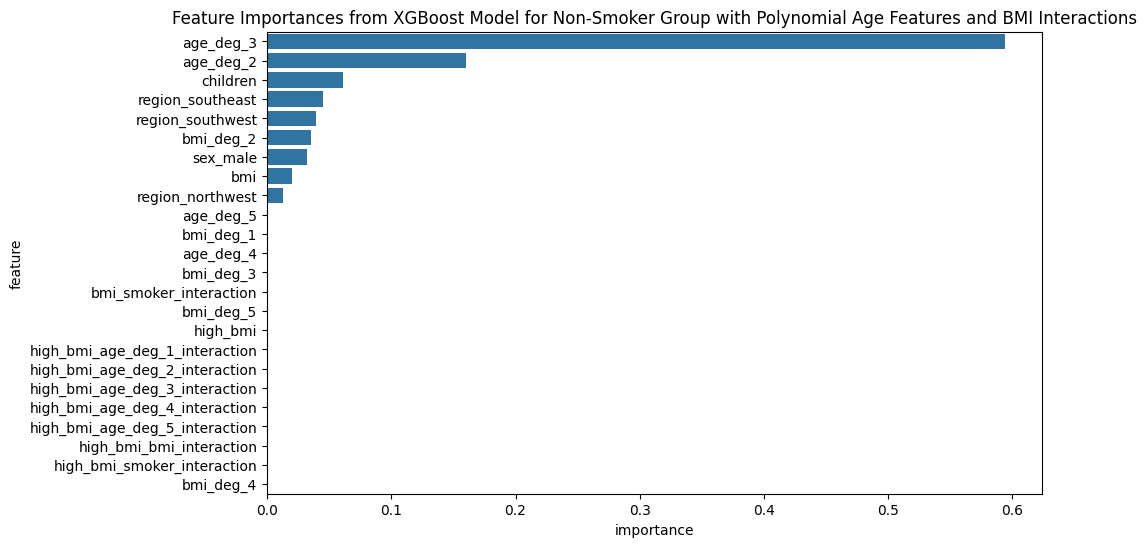

In [34]:
# get feature importances from the best_xgb_non_smoker_poly model
feature_importances = best_xgb_non_smoker.feature_importances_
# create a dataframe of feature importances
feature_importances_df = pd.DataFrame({'feature': X_test.columns, 'importance': feature_importances})
# sort the dataframe by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances from XGBoost Model for Non-Smoker Group with Polynomial Age Features and BMI Interactions')
plt.show()

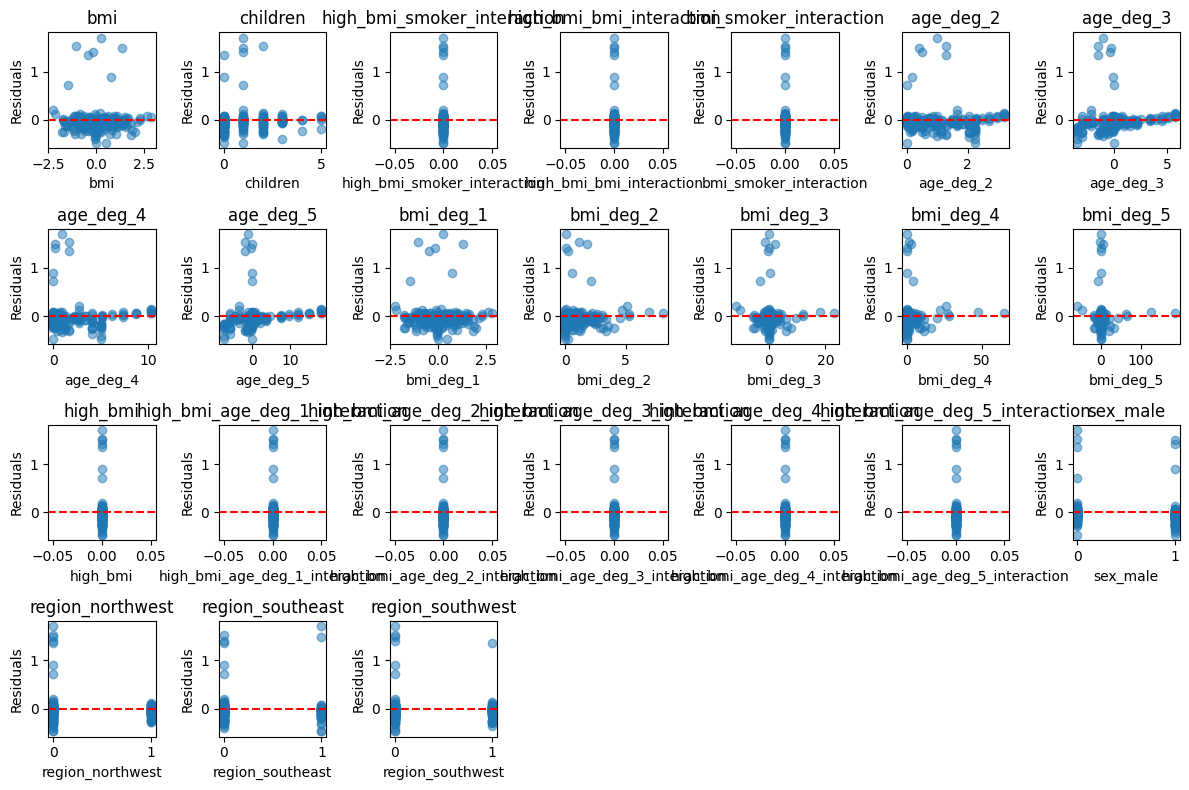

In [35]:
# plot residuals vs each of the individual features
import matplotlib.pyplot as plt
# Get residuals
residuals = y_test - y_pred_xgb_non_smoker
# Plot residuals
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_test.columns):
    plt.subplot(4, 7, i + 1)
    plt.scatter(X_test[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

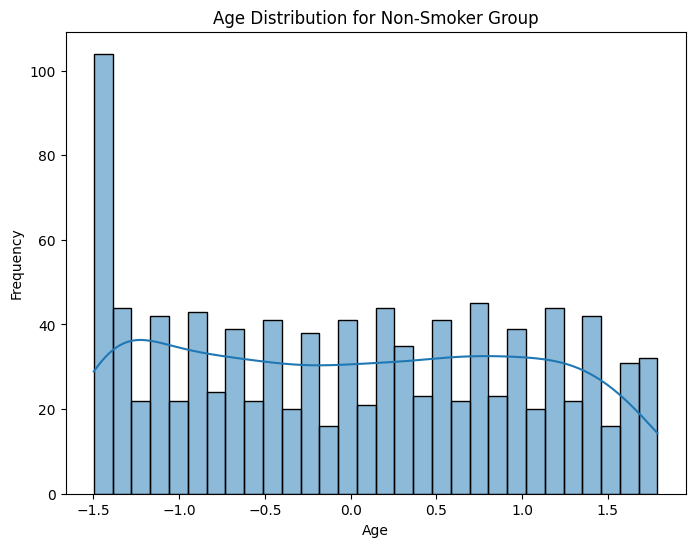

In [36]:
# See age distribution for non-smoker group
plt.figure(figsize=(8, 6))
sns.histplot(non_smoker_df['age'], bins=30, kde=True)
plt.title('Age Distribution for Non-Smoker Group')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

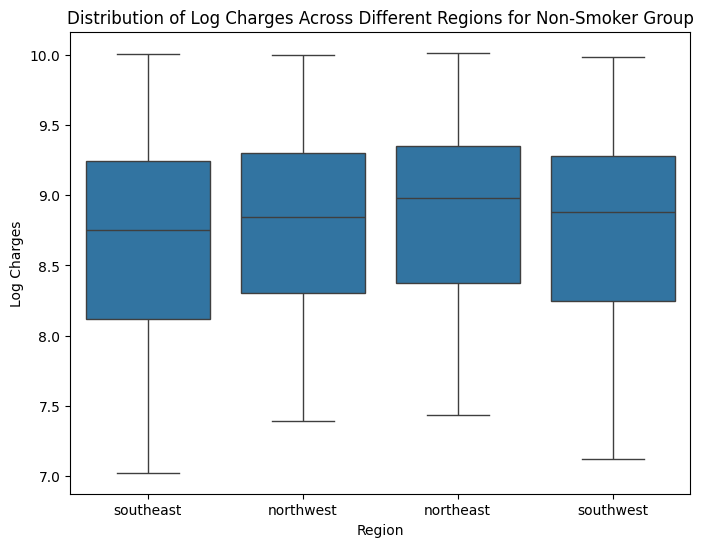

In [37]:
# distribution of charges across different regions for non-smoker group
plt.figure(figsize=(8, 6))
sns.boxplot(x='region', y='log_charges', data=non_smoker_df)
plt.title('Distribution of Log Charges Across Different Regions for Non-Smoker Group')
plt.xlabel('Region')
plt.ylabel('Log Charges')
plt.show()

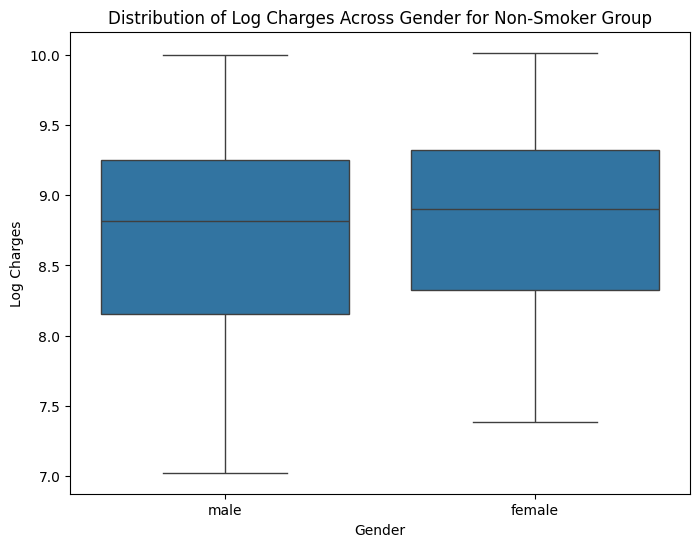

In [38]:
# distribution of charges across gender for non-smoker group
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='log_charges', data=non_smoker_df)
plt.title('Distribution of Log Charges Across Gender for Non-Smoker Group')
plt.xlabel('Gender')
plt.ylabel('Log Charges')
plt.show()

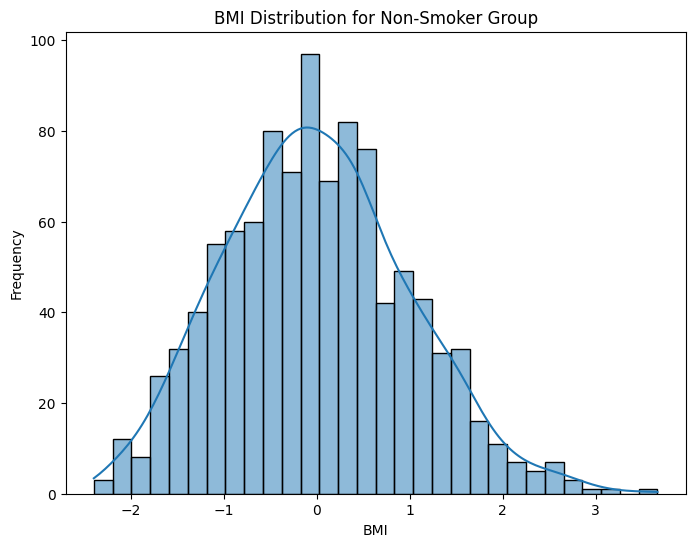

In [39]:
# distribution of bmi for non-smoker group
plt.figure(figsize=(8, 6))
sns.histplot(non_smoker_df['bmi'], bins=30, kde=True)
plt.title('BMI Distribution for Non-Smoker Group')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

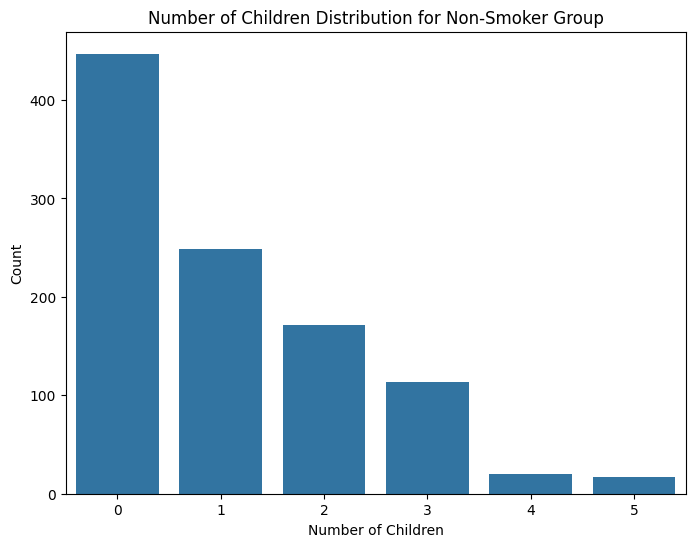

In [40]:
# distribution of number of children for non-smoker group
plt.figure(figsize=(8, 6))
sns.countplot(x='children', data=non_smoker_df)
plt.title('Number of Children Distribution for Non-Smoker Group')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

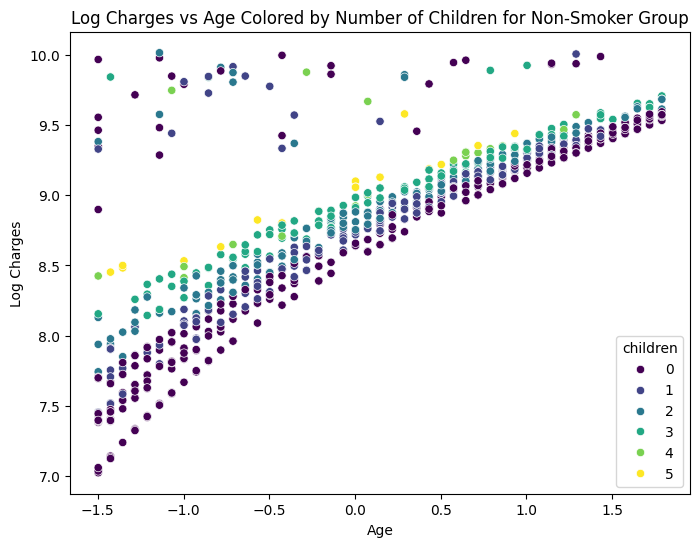

In [41]:
# Plot interaction between charges and age using number of children as hue for non-smoker group
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='log_charges', hue='children', data=non_smoker_df, palette='viridis')
plt.title('Log Charges vs Age Colored by Number of Children for Non-Smoker Group')
plt.xlabel('Age')
plt.ylabel('Log Charges')
plt.show()

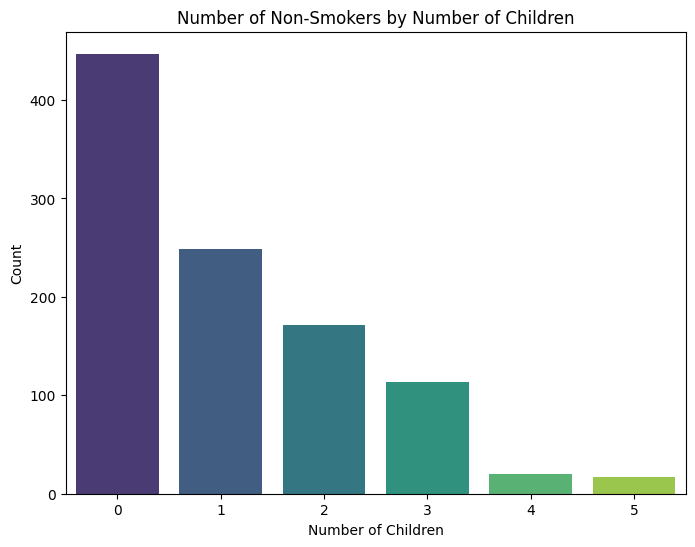

In [42]:
# Count number of non-smokers with n number of children
children_counts = non_smoker_df['children'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=children_counts.index, y=children_counts.values, palette='viridis')
plt.title('Number of Non-Smokers by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

In [43]:
# Create different models for number of children = 0 and number of children >=1 for non-smoker group
no_children_df = non_smoker_df[non_smoker_df['children'] == 0]
has_children_df = non_smoker_df[non_smoker_df['children'] >= 1]
# Define features and target variable for no children group
X_no_children = no_children_df.drop('log_charges', axis=1)
y_no_children = no_children_df['log_charges']
# One-hot encode categorical variables
X_no_children = pd.get_dummies(X_no_children, drop_first=True)
# Use train-test split
X_train_no_children, X_test_no_children, y_train_no_children, y_test_no_children = train_test_split(X_no_children, y_no_children, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for no children group
xgb_model_no_children = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_no_children = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_no_children = GridSearchCV(estimator=xgb_model_no_children, param_grid=param_grid_no_children, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_no_children.fit(X_train_no_children, y_train_no_children)
best_xgb_no_children = grid_search_xgb_no_children.best_estimator_
# Predict on the test data using the best XGBoost model for no children group
y_pred_xgb_no_children = best_xgb_no_children.predict(X_test_no_children)
# Evaluate the XGBoost model for no children group
mse_xgb_no_children = mean_squared_error(y_test_no_children, y_pred_xgb_no_children)
r2_xgb_no_children = r2_score(y_test_no_children, y_pred_xgb_no_children)
print(f'XGBoost Test MSE for Non-Smoker Group with No Children: {mse_xgb_no_children}')
print(f'XGBoost Test R2 for Non-Smoker Group with No Children: {r2_xgb_no_children}')   

# Define features and target variable for has children group
X_has_children = has_children_df.drop('log_charges', axis=1)
y_has_children = has_children_df['log_charges']
# One-hot encode categorical variables
X_has_children = pd.get_dummies(X_has_children, drop_first=True)        
# Use train-test split
X_train_has_children, X_test_has_children, y_train_has_children, y_test_has_children = train_test_split(X_has_children, y_has_children, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for has children group
xgb_model_has_children = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_has_children = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': range(3, 10, 1),
    'learning_rate': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_has_children = GridSearchCV(estimator=xgb_model_has_children, param_grid=param_grid_has_children, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_has_children.fit(X_train_has_children, y_train_has_children)
best_xgb_has_children = grid_search_xgb_has_children.best_estimator_
# Predict on the test data using the best XGBoost model for has children group
y_pred_xgb_has_children = best_xgb_has_children.predict(X_test_has_children)
# Evaluate the XGBoost model for has children group
mse_xgb_has_children = mean_squared_error(y_test_has_children, y_pred_xgb_has_children)
r2_xgb_has_children = r2_score(y_test_has_children, y_pred_xgb_has_children)
print(f'XGBoost Test MSE for Non-Smoker Group with Children: {mse_xgb_has_children}')
print(f'XGBoost Test R2 for Non-Smoker Group with Children: {r2_xgb_has_children}')

XGBoost Test MSE for Non-Smoker Group with No Children: 0.20042663607755556
XGBoost Test R2 for Non-Smoker Group with No Children: 0.6925920726447672
XGBoost Test MSE for Non-Smoker Group with Children: 0.10723468733503398
XGBoost Test R2 for Non-Smoker Group with Children: 0.6233463439192806


=== Test Set Metrics ===
MSE: 0.0581
RMSE: 0.2411
R2: 0.9323


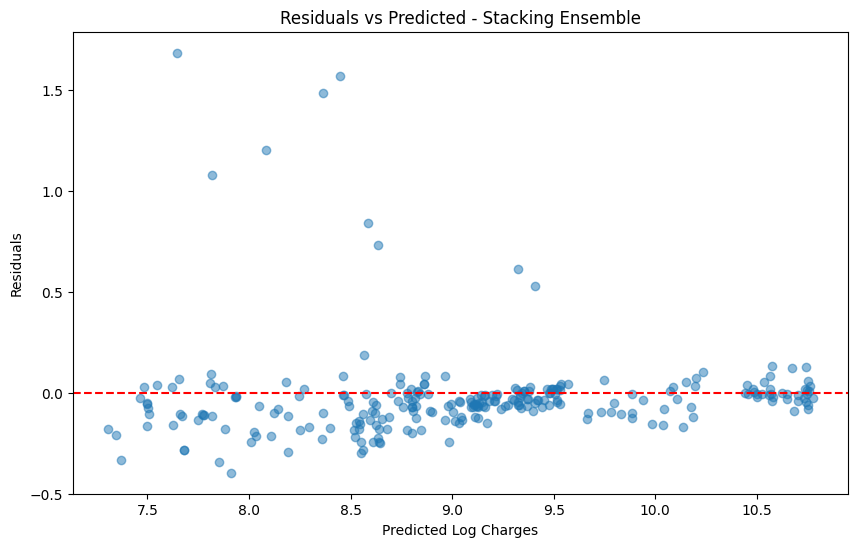

=== 10-Fold CV Metrics ===
CV RMSE: 0.3113
CV R2: 0.8817


In [44]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

# Prepare Data
y = data_df['log_charges']  # already log-transformed
X = data_df.drop(columns=['log_charges'])
X = pd.get_dummies(X, drop_first=True)  # one-hot encoding for categorical variables

# 80/20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Flatten y to avoid shape warnings
y_train = y_train.ravel() if len(y_train.shape) > 1 else y_train
y_test = y_test.ravel() if len(y_test.shape) > 1 else y_test

# Define Base Models
# Random Forest
rf_model_wrapped = RandomForestRegressor(
    n_estimators=100, max_depth=5, random_state=42
)

# XGBoost
xgb_model_wrapped = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

# LightGBM
lgb_model_wrapped = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=100,
        max_depth=5,
        min_child_samples=20,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# Define Stacking Ensemble
estimators = [
    ('rf', rf_model_wrapped),
    ('xgb', xgb_model_wrapped),
    ('lgb', lgb_model_wrapped)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,  # inner CV for meta-model
    n_jobs=-1
)

# Fit Stacking Ensemble
stacking_model.fit(X_train, y_train)

# Predict & Evaluate on Test Set
y_pred = stacking_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== Test Set Metrics ===")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Stacking Ensemble')
plt.show()

# 10-Fold Cross-Validation Metrics
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# CV RMSE
cv_mse_scores = -cross_val_score(
    stacking_model, X_train, y_train,
    cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)
cv_rmse = np.sqrt(np.mean(cv_mse_scores))

# CV R2
cv_r2_scores = cross_val_score(
    stacking_model, X_train, y_train,
    cv=cv, scoring='r2', n_jobs=-1
)
cv_r2 = np.mean(cv_r2_scores)

print("=== 10-Fold CV Metrics ===")
print(f"CV RMSE: {cv_rmse:.4f}")
print(f"CV R2: {cv_r2:.4f}")


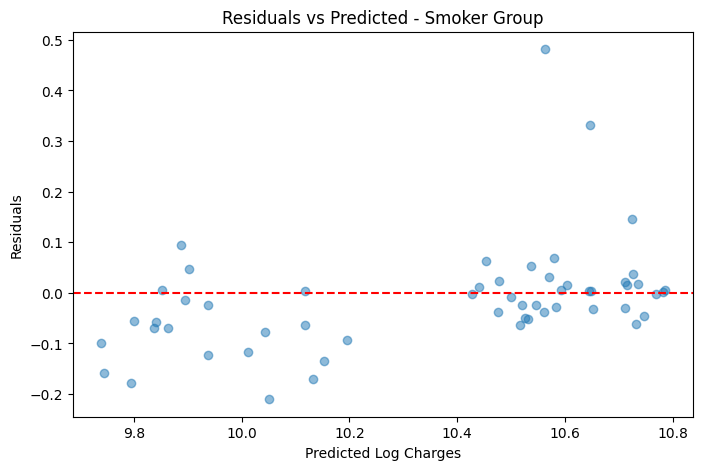

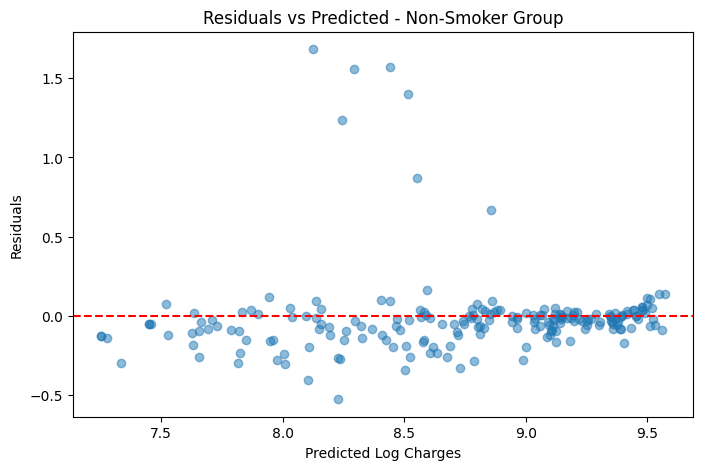

===== Smoker Group =====
Test MSE: 0.0116
Test RMSE: 0.1075
Test R2: 0.9277
10-Fold CV RMSE: 0.1358
10-Fold CV R2: 0.8525

===== Non-Smoker Group =====
Test MSE: 0.0754
Test RMSE: 0.2746
Test R2: 0.8325
10-Fold CV RMSE: 0.3466
10-Fold CV R2: 0.7507


In [45]:
# Stacking Ensemble (Random Forest + XGBoost + LightGBM)
# - Split by smoker / non-smoker

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

# Split by smoker
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']

def prepare_X_y(df):
    """Prepare features and target, one-hot encode categorical variables"""
    y = df['log_charges']  # already log-transformed
    X = df.drop(columns=['log_charges'])
    X = pd.get_dummies(X, drop_first=True)
    return X, y

X_s, y_s = prepare_X_y(smoker_df)
X_ns, y_ns = prepare_X_y(non_smoker_df)

# Train-test split (80/20)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42
)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size=0.2, random_state=42
)

# Define base models
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror', n_estimators=100, max_depth=5,
        learning_rate=0.05, random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression', boosting_type='gbdt', learning_rate=0.05,
        num_leaves=31, n_estimators=100, min_child_samples=20, max_depth=5,
        random_state=42, verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# Define stacking ensemble
estimators = [('rf', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)]
stacking_model = StackingRegressor(
    estimators=estimators, final_estimator=Ridge(alpha=1.0), cv=5, n_jobs=-1
)

# Fit & evaluate function
def fit_and_evaluate(X_train, X_test, y_train, y_test, model, group_name=''):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Residual plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Log Charges')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted - {group_name} Group')
    plt.show()

    # 10-Fold CV metrics
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    cv_mse_scores = -cross_val_score(
        model, X_train, y_train, cv=cv,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_r2_mean = np.mean(cv_r2_scores)

    return mse, rmse, r2, cv_rmse_mean, cv_r2_mean

# Evaluate smoker group
mse_s, rmse_s, r2_s, cv_rmse_s, cv_r2_s = fit_and_evaluate(
    X_train_s, X_test_s, y_train_s, y_test_s, stacking_model, group_name='Smoker'
)

# Evaluate non-smoker group
mse_ns, rmse_ns, r2_ns, cv_rmse_ns, cv_r2_ns = fit_and_evaluate(
    X_train_ns, X_test_ns, y_train_ns, y_test_ns, stacking_model, group_name='Non-Smoker'
)

# Results
print("===== Smoker Group =====")
print(f"Test MSE: {mse_s:.4f}")
print(f"Test RMSE: {rmse_s:.4f}")
print(f"Test R2: {r2_s:.4f}")
print(f"10-Fold CV RMSE: {cv_rmse_s:.4f}")
print(f"10-Fold CV R2: {cv_r2_s:.4f}")

print("\n===== Non-Smoker Group =====")
print(f"Test MSE: {mse_ns:.4f}")
print(f"Test RMSE: {rmse_ns:.4f}")
print(f"Test R2: {r2_ns:.4f}")
print(f"10-Fold CV RMSE: {cv_rmse_ns:.4f}")
print(f"10-Fold CV R2: {cv_r2_ns:.4f}")


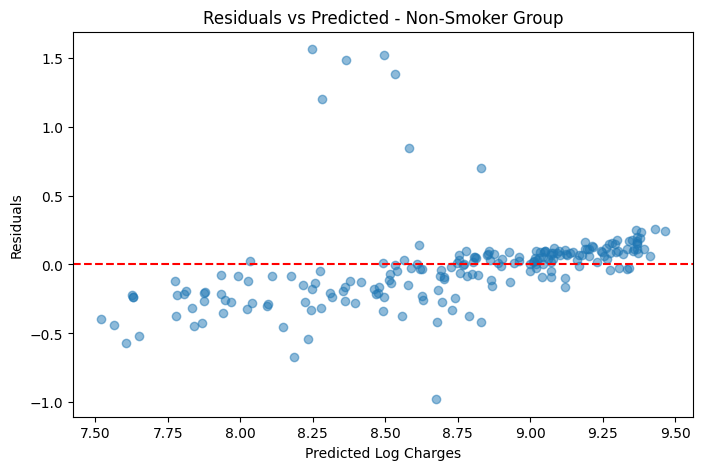

Non-Smoker Group Results
Test MSE: 0.0952
Test RMSE: 0.3086
Test R2: 0.7885
10-Fold CV RMSE: 0.3666
10-Fold CV R2: 0.7231


In [46]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import ElasticNet

# Filter non-smoker data and create additional polynomial/interactions features
non_smoker_df = data_df[data_df['smoker'] == 'no'].copy()
non_smoker_df['age_sq'] = non_smoker_df['age'] ** 2
non_smoker_df['bmi_sq'] = non_smoker_df['bmi'] ** 2
non_smoker_df['age_bmi'] = non_smoker_df['age'] * non_smoker_df['bmi']
non_smoker_df['bmi_children'] = non_smoker_df['bmi'] * non_smoker_df['children']

# Prepare features and target
y = non_smoker_df['log_charges']  # log-transformed target
X = non_smoker_df.drop(columns=['log_charges'])
X = pd.get_dummies(X, drop_first=True)  # one-hot encode categorical variables

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models for stacking ensemble
rf_model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        objective='reg:squarederror'
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression', boosting_type='gbdt',
        learning_rate=0.05, num_leaves=31, max_depth=5,
        min_child_samples=20, n_estimators=200,
        random_state=42, verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# Create stacking ensemble using ElasticNet as final estimator
estimators = [('rf', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    cv=10,
    n_jobs=-1
)

# Fit the model
stacking_model.fit(X_train, y_train)

# Predict on test set
y_pred = stacking_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Residual plot to check errors
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Non-Smoker Group')
plt.show()

# Cross-validated metrics (10-fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(stacking_model, X_train, y_train,
                                 cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

cv_r2_scores = cross_val_score(stacking_model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

# Print results
print("Non-Smoker Group Results")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")
print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")


Non-Smoker Group - VLR Results
Test MSE: 0.0919
Test RMSE: 0.3032
Test R2: 0.7958


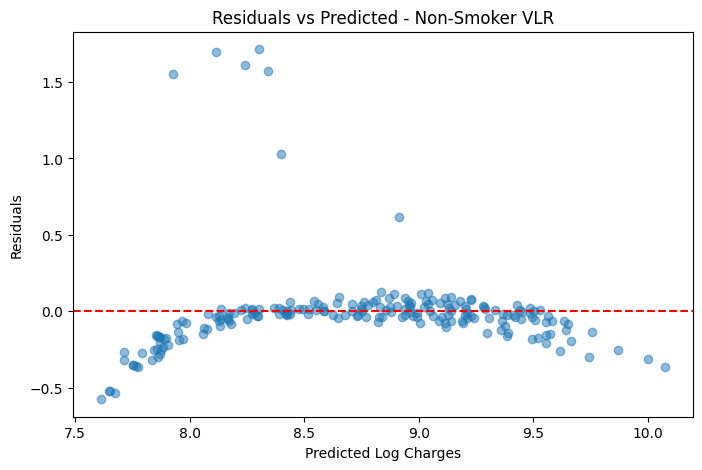

10-Fold CV RMSE: 0.3462
10-Fold CV R2: 0.7530


In [47]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare features dynamically
def prepare_X_y(df):
    y = df['log_charges']  # target is already log-transformed
    X = df.drop(columns=['log_charges'])
    X = pd.get_dummies(X, drop_first=True)  # one-hot encode categorical variables
    return X, y

# Filter non-smokers
non_smoker_df = data_df[data_df['smoker'] == 'no']
X_ns, y_ns = prepare_X_y(non_smoker_df)

# Train-test split 80/20
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size=0.2, random_state=42
)

# Fit VLR (standard linear regression)
vlr_model = LinearRegression()
vlr_model.fit(X_train_ns, y_train_ns)

# Predict
y_pred_ns = vlr_model.predict(X_test_ns)

# Test metrics
mse_ns = mean_squared_error(y_test_ns, y_pred_ns)
rmse_ns = np.sqrt(mse_ns)
r2_ns = r2_score(y_test_ns, y_pred_ns)

print("Non-Smoker Group - VLR Results")
print(f"Test MSE: {mse_ns:.4f}")
print(f"Test RMSE: {rmse_ns:.4f}")
print(f"Test R2: {r2_ns:.4f}")

# Residual plot
residuals = y_test_ns - y_pred_ns
plt.figure(figsize=(8,5))
plt.scatter(y_pred_ns, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Log Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted - Non-Smoker VLR")
plt.show()

# 10-Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(vlr_model, X_train_ns, y_train_ns, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))
cv_r2_scores = cross_val_score(vlr_model, X_train_ns, y_train_ns, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")


Non-Smoker Group - Ridge with Polynomial Features Results
Test MSE: 0.0807
Test RMSE: 0.2841
Test R2: 0.8207
10-Fold CV RMSE: 0.3355
10-Fold CV R2: 0.7680


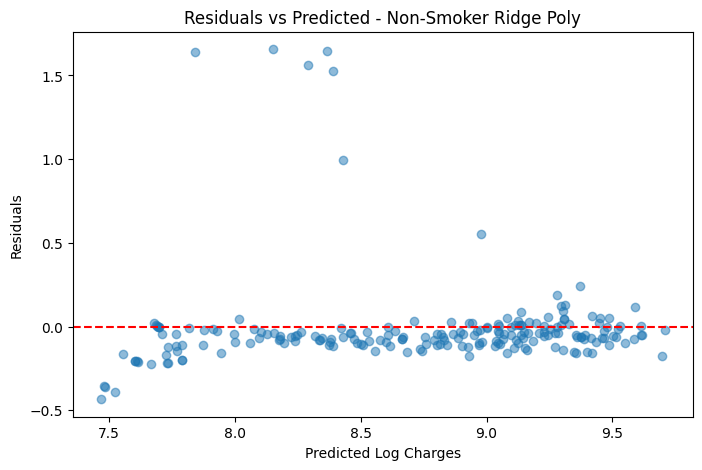

In [48]:
non_smoker_df = data_df[data_df['smoker'] == 'no']

# Prepare X and y with categorical variables one-hot encoded
y = non_smoker_df['log_charges']
X = non_smoker_df.drop(columns=['log_charges'])
X = pd.get_dummies(X, drop_first=True)

# Add polynomial features (up to degree 2) for numerical columns only
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
num_cols = ['age', 'bmi', 'children']
X_poly = poly.fit_transform(X[num_cols])
poly_feature_names = poly.get_feature_names_out(num_cols)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)

# Combine polynomial features with remaining features
X_rest = X.drop(columns=num_cols)
X_final = pd.concat([X_rest, X_poly_df], axis=1)

# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# Wrap Ridge Regression to handle log-transformed target
ridge_model = TransformedTargetRegressor(
    regressor=Ridge(alpha=1.0),
    func=np.log1p,
    inverse_func=np.expm1
)

# Fit model
ridge_model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Non-Smoker Group - Ridge with Polynomial Features Results")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2: {r2:.4f}")

# 10-Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(
    ridge_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))
cv_r2_scores = cross_val_score(ridge_model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Non-Smoker Ridge Poly')
plt.show()


Non-Smoker Group - Stacking Ensemble with Polynomial Features
Test MSE: 0.0743
Test RMSE: 0.2727
Test R2: 0.8348
10-Fold CV RMSE: 0.3480
10-Fold CV R2: 0.7491


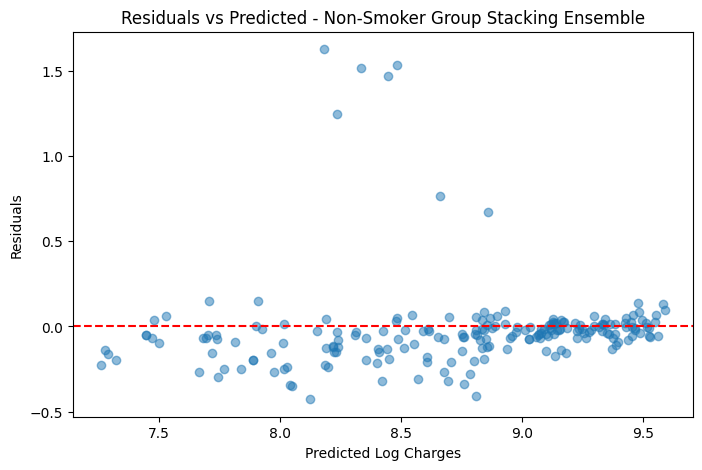

In [49]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline

non_smoker_df = data_df[data_df['smoker']=='no']
y_ns = non_smoker_df['log_charges']
X_ns = non_smoker_df.drop(columns=['log_charges'])
X_ns = pd.get_dummies(X_ns, drop_first=True)

# Train-test split 80/20
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size=0.2, random_state=42
)

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Base models with TransformedTargetRegressor for log-transform
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(objective='regression', boosting_type='gbdt',
                                 learning_rate=0.05, num_leaves=31, n_estimators=100,
                                 min_child_samples=20, max_depth=5, random_state=42, verbose=-1),
    func=np.log1p, inverse_func=np.expm1
)

estimators = [('rf', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=10,  # 10-fold CV
    n_jobs=-1
)

# Pipeline: polynomial features + stacking
stacking_pipeline = Pipeline([
    ('poly', poly),
    ('stack', stacking_model)
])

# Fit model
stacking_pipeline.fit(X_train_ns, y_train_ns)

# Predict
y_pred_ns = stacking_pipeline.predict(X_test_ns)

# Metrics
mse_ns = mean_squared_error(y_test_ns, y_pred_ns)
rmse_ns = np.sqrt(mse_ns)
r2_ns = r2_score(y_test_ns, y_pred_ns)

# Cross-validated metrics
cv = KFold(n_splits=10, shuffle=True, random_state=42)

cv_mse_scores = -cross_val_score(stacking_pipeline, X_train_ns, y_train_ns, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

cv_r2_scores = cross_val_score(stacking_pipeline, X_train_ns, y_train_ns, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

# Print results
print("Non-Smoker Group - Stacking Ensemble with Polynomial Features")
print(f"Test MSE: {mse_ns:.4f}")
print(f"Test RMSE: {rmse_ns:.4f}")
print(f"Test R2: {r2_ns:.4f}")
print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")

# Residual plot
residuals = y_test_ns - y_pred_ns
plt.figure(figsize=(8,5))
plt.scatter(y_pred_ns, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Non-Smoker Group Stacking Ensemble')
plt.show()


Smoker Group - Stacking Ensemble + Polynomial Features
Test MSE: 0.0126
Test RMSE: 0.1122
Test R2: 0.9212
10-Fold CV RMSE: 0.1377
10-Fold CV R2: 0.8491


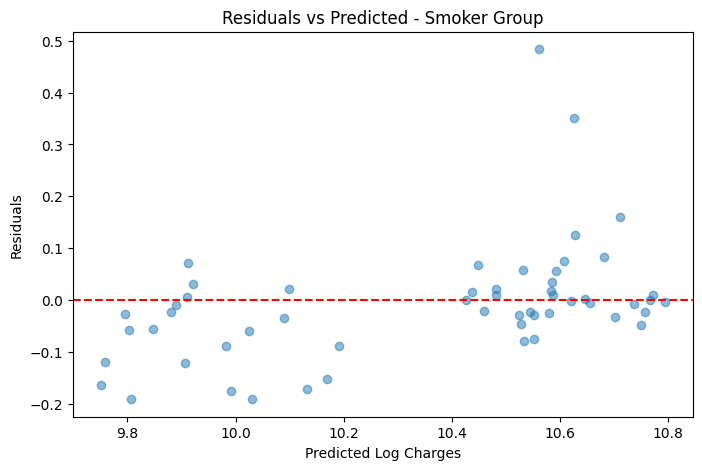

In [50]:
import warnings
warnings.filterwarnings('ignore')

# ----- Prepare smoker data -----
smoker_df = data_df[data_df['smoker'] == 'yes']

y_s = smoker_df['log_charges']
X_s = smoker_df.drop(columns=['log_charges'])
X_s = pd.get_dummies(X_s, drop_first=True)

# Train-test split 80/20
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42
)

# ----- Polynomial Features -----
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_s)
X_test_poly = poly.transform(X_test_s)

# ----- Define base models -----
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=100,
        min_child_samples=20,
        max_depth=5,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# ----- Stacking Ensemble -----
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=10,  # 10-fold CV
    n_jobs=-1
)

# ----- Pipeline: Polynomial + Stacking -----
stacking_pipeline = Pipeline([
    ('poly', poly),
    ('stack', stacking_model)
])

# ----- Fit model -----
stacking_pipeline.fit(X_train_s, y_train_s)

# ----- Predict & Evaluate -----
y_pred_s = stacking_pipeline.predict(X_test_s)

mse_s = mean_squared_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_s, y_pred_s)

print("Smoker Group - Stacking Ensemble + Polynomial Features")
print(f"Test MSE: {mse_s:.4f}")
print(f"Test RMSE: {rmse_s:.4f}")
print(f"Test R2: {r2_s:.4f}")

# ----- 10-Fold CV Metrics -----
cv = KFold(n_splits=10, shuffle=True, random_state=42)

cv_mse_scores = -cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

cv_r2_scores = cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")

# ----- Residual Plot -----
residuals_s = y_test_s - y_pred_s
plt.figure(figsize=(8,5))
plt.scatter(y_pred_s, residuals_s, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Smoker Group')
plt.show()

Smoker Group - Stacking Ensemble + Polynomial (Age & BMI, deg=3)
Test MSE: 0.0125
Test RMSE: 0.1119
Test R2: 0.9217
10-Fold CV RMSE: 0.1379
10-Fold CV R2: 0.8486


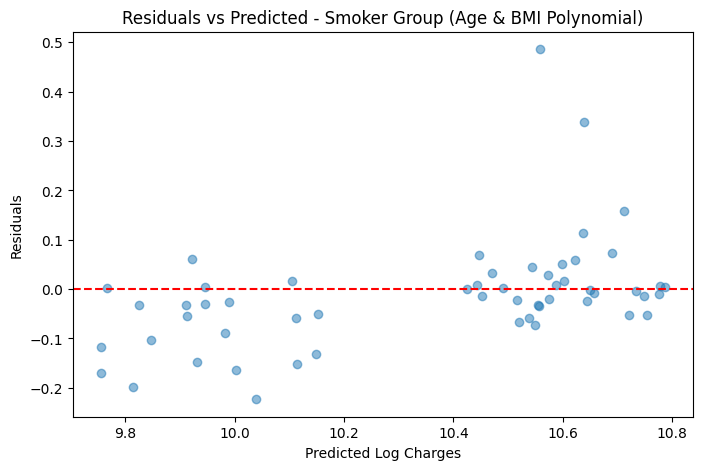

In [51]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# ----- Prepare smoker data -----
smoker_df = data_df[data_df['smoker'] == 'yes']
y_s = smoker_df['log_charges']
X_s = smoker_df.drop(columns=['log_charges'])
X_s = pd.get_dummies(X_s, drop_first=True)

# Train-test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42
)

# ----- Select columns -----
poly_features = ['age', 'bmi']
numeric_features = ['children']
categorical_features = [col for col in X_s.columns if 'sex_' in col or 'region_' in col]

# ----- Preprocessor -----
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop'
)

# ----- Define base models -----
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=100,
        min_child_samples=20,
        max_depth=5,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# ----- Stacking Ensemble -----
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=10,
    n_jobs=-1
)

# ----- Full Pipeline -----
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stack', stacking_model)
])

# ----- Fit model -----
stacking_pipeline.fit(X_train_s, y_train_s)

# ----- Predict & Evaluate -----
y_pred_s = stacking_pipeline.predict(X_test_s)

mse_s = mean_squared_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_s, y_pred_s)

print("Smoker Group - Stacking Ensemble + Polynomial (Age & BMI, deg=3)")
print(f"Test MSE: {mse_s:.4f}")
print(f"Test RMSE: {rmse_s:.4f}")
print(f"Test R2: {r2_s:.4f}")

# ----- 10-Fold CV -----
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

cv_r2_scores = cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")

# ----- Residual Plot -----
residuals_s = y_test_s - y_pred_s
plt.figure(figsize=(8,5))
plt.scatter(y_pred_s, residuals_s, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Smoker Group (Age & BMI Polynomial)')
plt.show()

Non-Smoker Group - Stacking Ensemble + Polynomial (Age & BMI, deg=3)
Test MSE: 0.0777
Test RMSE: 0.2788
Test R2: 0.8273
10-Fold CV RMSE: 0.3483
10-Fold CV R2: 0.7487


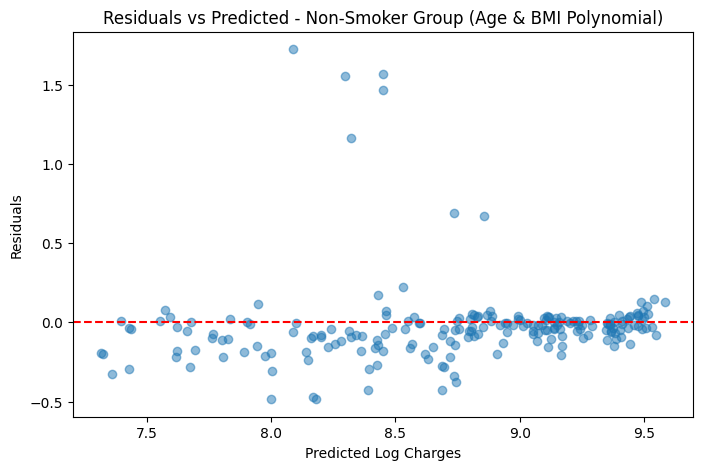

In [52]:
# ----- Prepare non-smoker data -----
nonsmoker_df = data_df[data_df['smoker'] == 'no']
y_ns = nonsmoker_df['log_charges']
X_ns = nonsmoker_df.drop(columns=['log_charges'])
X_ns = pd.get_dummies(X_ns, drop_first=True)

# Train-test split
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size=0.2, random_state=42
)

# ----- Select columns -----
poly_features = ['age', 'bmi']
numeric_features = ['children']
categorical_features = [col for col in X_ns.columns if 'sex_' in col or 'region_' in col]

# ----- Preprocessor -----
preprocessor_ns = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop'
)

# ----- Define base models -----
rf_model_ns = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

xgb_model_ns = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model_ns = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=100,
        min_child_samples=20,
        max_depth=5,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# ----- Stacking Ensemble -----
estimators_ns = [
    ('rf', rf_model_ns),
    ('xgb', xgb_model_ns),
    ('lgb', lgb_model_ns)
]

stacking_model_ns = StackingRegressor(
    estimators=estimators_ns,
    final_estimator=Ridge(alpha=1.0),
    cv=10,
    n_jobs=-1
)

# ----- Full Pipeline -----
stacking_pipeline_ns = Pipeline([
    ('preprocessor', preprocessor_ns),
    ('stack', stacking_model_ns)
])

# ----- Fit model -----
stacking_pipeline_ns.fit(X_train_ns, y_train_ns)

# ----- Predict & Evaluate -----
y_pred_ns = stacking_pipeline_ns.predict(X_test_ns)

mse_ns = mean_squared_error(y_test_ns, y_pred_ns)
rmse_ns = np.sqrt(mse_ns)
r2_ns = r2_score(y_test_ns, y_pred_ns)

print("Non-Smoker Group - Stacking Ensemble + Polynomial (Age & BMI, deg=3)")
print(f"Test MSE: {mse_ns:.4f}")
print(f"Test RMSE: {rmse_ns:.4f}")
print(f"Test R2: {r2_ns:.4f}")

# ----- 10-Fold CV -----
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores_ns = -cross_val_score(stacking_pipeline_ns, X_train_ns, y_train_ns, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean_ns = np.sqrt(np.mean(cv_mse_scores_ns))

cv_r2_scores_ns = cross_val_score(stacking_pipeline_ns, X_train_ns, y_train_ns, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean_ns = np.mean(cv_r2_scores_ns)

print(f"10-Fold CV RMSE: {cv_rmse_mean_ns:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean_ns:.4f}")

# ----- Residual Plot -----
residuals_ns = y_test_ns - y_pred_ns
plt.figure(figsize=(8,5))
plt.scatter(y_pred_ns, residuals_ns, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Non-Smoker Group (Age & BMI Polynomial)')
plt.show()


Smoker Group - Stacking Ensemble + Polynomial (Age deg=3, BMI deg=2)
Test MSE: 0.0117
Test RMSE: 0.1080
Test R2: 0.9270
10-Fold CV RMSE: 0.1378
10-Fold CV R2: 0.8479


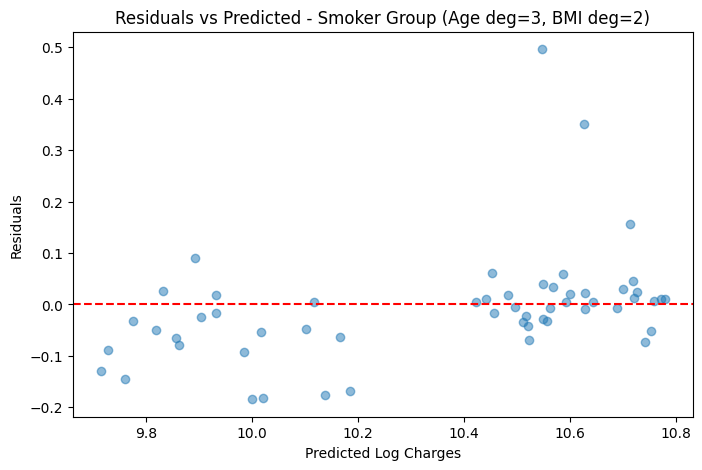

In [53]:
#Polynomial 3 on age & 2 on BMI

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# ----- Prepare smoker data -----
smoker_df = data_df[data_df['smoker'] == 'yes']
y_s = smoker_df['log_charges']
X_s = smoker_df.drop(columns=['log_charges'])
X_s = pd.get_dummies(X_s, drop_first=True)

# Train-test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, random_state=42
)

# ----- Columns -----
poly_age = ['age']
poly_bmi = ['bmi']
numeric_features = ['children']
categorical_features = [col for col in X_s.columns if 'sex_' in col or 'region_' in col]

# ----- Preprocessor with separate polynomial degrees -----
preprocessor = ColumnTransformer(
    transformers=[
        ('poly_age', PolynomialFeatures(degree=3, include_bias=False), poly_age),
        ('poly_bmi', PolynomialFeatures(degree=2, include_bias=False), poly_bmi),
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop'
)

# ----- Base models with tuned params -----
rf_model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)

xgb_model = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.03,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.03,
        num_leaves=31,
        n_estimators=300,
        min_child_samples=20,
        max_depth=6,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# ----- Stacking Ensemble -----
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=10,
    n_jobs=-1
)

# ----- Full Pipeline -----
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler_poly', StandardScaler()),  # optional: scale after polynomial
    ('stack', stacking_model)
])

# ----- Fit model -----
stacking_pipeline.fit(X_train_s, y_train_s)

# ----- Predict & Evaluate -----
y_pred_s = stacking_pipeline.predict(X_test_s)

mse_s = mean_squared_error(y_test_s, y_pred_s)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_s, y_pred_s)

print("Smoker Group - Stacking Ensemble + Polynomial (Age deg=3, BMI deg=2)")
print(f"Test MSE: {mse_s:.4f}")
print(f"Test RMSE: {rmse_s:.4f}")
print(f"Test R2: {r2_s:.4f}")

# ----- 10-Fold CV -----
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean = np.sqrt(np.mean(cv_mse_scores))

cv_r2_scores = cross_val_score(stacking_pipeline, X_train_s, y_train_s, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean = np.mean(cv_r2_scores)

print(f"10-Fold CV RMSE: {cv_rmse_mean:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean:.4f}")

# ----- Residual Plot -----
residuals_s = y_test_s - y_pred_s
plt.figure(figsize=(8,5))
plt.scatter(y_pred_s, residuals_s, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Smoker Group (Age deg=3, BMI deg=2)')
plt.show()

In [ ]:
# ----- Prepare non-smoker data -----
nonsmoker_df = data_df[data_df['smoker'] == 'no']
y_ns = nonsmoker_df['log_charges']
X_ns = nonsmoker_df.drop(columns=['log_charges'])
X_ns = pd.get_dummies(X_ns, drop_first=True)

# Train-test split
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size=0.2, random_state=42
)

# ----- Columns -----
poly_age = ['age']
poly_bmi = ['bmi']
numeric_features = ['children']
categorical_features = [col for col in X_ns.columns if 'sex_' in col or 'region_' in col]

# ----- Preprocessor with separate polynomial degrees -----
preprocessor_ns = ColumnTransformer(
    transformers=[
        ('poly_age', PolynomialFeatures(degree=3, include_bias=False), poly_age),
        ('poly_bmi', PolynomialFeatures(degree=2, include_bias=False), poly_bmi),
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ],
    remainder='drop'
)

# ----- Base models -----
rf_model_ns = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)

xgb_model_ns = TransformedTargetRegressor(
    regressor=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.03,
        random_state=42
    ),
    func=np.log1p, inverse_func=np.expm1
)

lgb_model_ns = TransformedTargetRegressor(
    regressor=lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        learning_rate=0.03,
        num_leaves=31,
        n_estimators=300,
        min_child_samples=20,
        max_depth=6,
        random_state=42,
        verbose=-1
    ),
    func=np.log1p, inverse_func=np.expm1
)

# ----- Stacking Ensemble -----
estimators_ns = [
    ('rf', rf_model_ns),
    ('xgb', xgb_model_ns),
    ('lgb', lgb_model_ns)
]

stacking_model_ns = StackingRegressor(
    estimators=estimators_ns,
    final_estimator=Ridge(alpha=1.0),
    cv=10,
    n_jobs=-1
)

# ----- Full Pipeline -----
stacking_pipeline_ns = Pipeline([
    ('preprocessor', preprocessor_ns),
    ('scaler_poly', StandardScaler()),
    ('stack', stacking_model_ns)
])

# ----- Fit model -----
stacking_pipeline_ns.fit(X_train_ns, y_train_ns)

# ----- Predict & Evaluate -----
y_pred_ns = stacking_pipeline_ns.predict(X_test_ns)

mse_ns = mean_squared_error(y_test_ns, y_pred_ns)
rmse_ns = np.sqrt(mse_ns)
r2_ns = r2_score(y_test_ns, y_pred_ns)

print("Non-Smoker Group - Stacking Ensemble + Polynomial (Age deg=3, BMI deg=2)")
print(f"Test MSE: {mse_ns:.4f}")
print(f"Test RMSE: {rmse_ns:.4f}")
print(f"Test R2: {r2_ns:.4f}")

# ----- 10-Fold CV -----
cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores_ns = -cross_val_score(stacking_pipeline_ns, X_train_ns, y_train_ns, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_mean_ns = np.sqrt(np.mean(cv_mse_scores_ns))

cv_r2_scores_ns = cross_val_score(stacking_pipeline_ns, X_train_ns, y_train_ns, cv=cv, scoring='r2', n_jobs=-1)
cv_r2_mean_ns = np.mean(cv_r2_scores_ns)

print(f"10-Fold CV RMSE: {cv_rmse_mean_ns:.4f}")
print(f"10-Fold CV R2: {cv_r2_mean_ns:.4f}")

# ----- Residual Plot -----
residuals_ns = y_test_ns - y_pred_ns
plt.figure(figsize=(8,5))
plt.scatter(y_pred_ns, residuals_ns, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted - Non-Smoker Group (Age deg=3, BMI deg=2)')
plt.show()

Non-Smoker Group - Stacking Ensemble + Polynomial (Age deg=3, BMI deg=2)
Test MSE: 0.0814
Test RMSE: 0.2853
Test R2: 0.8192
